In [1]:
import numpy as np
import scipy as sp
import pandas as pd
from numpy import random
from numpy import matlib
import matplotlib.pyplot as plt
import matplotlib
import math
# https://pypi.python.org/pypi/haversine
from haversine import haversine
%matplotlib inline
import sys
import time
 
import networkx as nx

import math

from gurobipy import *
import gurobipy as grb
from gurobipy import GRB
import cvxpy as cvx




In [2]:
import pandas as pd;
import numpy as np;
from haversine import haversine
from gurobipy import *
import gurobipy as grb
from gurobipy import GRB
import cvxpy as cvx
from numpy import random

class Problem:
    
    def __init__(self, data, sample_submission=None):
        
        """
        input:
        
        data - данные об исходной проблеме в формате dataframe pandas со столбцами 
        GiftId, Latitude, Longitude, Weight
        
        sample_submission - начальное решение проблемы. Формат dataframe pandas со столбцами GiftId and TripId.
        GiftId should be ordered by the order of delivery, and different trips should have different TripIds. 
        
        """
        
        self.df_data=data
        # количество точек, включая полюс 
        self.N = data.shape[0]+1
        # вес саней
        self.weight_sleighs=10
        # лимит саней
        self.weight_limit = 1000 
        # вес подарков плюс сани
        self.weights=np.asarray(data.Weight)
        # self.weights=np.append(self.weights, self.weight_sleighs)
    
        # стартовая позиция (Lat=90, Long=0)
        # широта, долгота
        self.lat=np.asarray(data.Latitude)*(np.pi/180.0)
        self.lat=np.append(self.lat, 90*np.pi/180)
        self.long=np.asarray(data.Longitude)*(np.pi/180.0)
        self.long=np.append(self.long,0)
        self.Earth_radius=6371
        
        # разница в широте
        dlat = \
            np.matlib.repmat(self.lat,self.N,1) - \
            np.matlib.repmat(self.lat,self.N,1).transpose();
        # разница в долготе
        dlong = \
            np.matlib.repmat(self.long,self.N,1) - \
            np.matlib.repmat(self.long,self.N,1).transpose();
        
        # cos широты
        cos_lat=np.cos(self.lat).reshape(1,self.N)
        
        # harvesine distance
        # https://en.wikipedia.org/wiki/Great-circle_distance
        # расстояние между точками
        self.dist=self.Earth_radius*2* \
                 np.arcsin(np.sqrt(np.sin(dlat/2.0)**2 \
                 +cos_lat*cos_lat.T*np.sin(dlong/2.0)**2))  
    
        # решение
        self.solution=sample_submission
    
        # значение целевой функции
        self.obj=np.inf
        # weighted_reindeer_weariness(self.solution)

    def weighted_onetrip_weariness(self, onetrip): 

        """
        input:

        onetrip - последовательность развоза подарков для одного трипа (с северного полюса и обратно). 
        формат numpy array в которых содержатся GiftId.GiftId should be ordered by the order of delivery. 

        output: 

        obj - значение целевой функции для одного трипа (формат float)

        """

        obj_onetrip = 0.0          
        prev_stop = self.N-1 #начинаем с северного полюса, идем в обратном направлении по маршруту
        prev_weight = self.weight_sleighs
        for i in onetrip[::-1]:
            obj_onetrip += self.dist[prev_stop,i] * prev_weight
            prev_stop = i
            prev_weight += self.weights[i]
            
        if prev_weight > self.weight_limit + self.weight_sleighs:
            return np.inf

        # плюс маршрут с северного полюса    
        obj_onetrip += self.dist[prev_stop,self.N-1] * prev_weight

        return obj_onetrip
        

    def objective(self, all_trips):
        
        """
        input:
        
        all_trips - решение исходной проблемы в формате dataframe pandas со столбцами GiftId and TripId.
        GiftId should be ordered by the order of delivery, and different trips should have different TripIds. 
        
        output: 
        
        obj - значение целевой функции (формат float)
        
        """
        
        n=all_trips.shape[0]
        
        uniq_gifts = all_trips.GiftId.unique()
    
        uniq_trips = all_trips.TripId.unique()

        obj = 0.0
        for i in uniq_trips:
            trip = np.asarray(all_trips[all_trips.TripId==i].GiftId)-1
            wrw = self.weighted_onetrip_weariness(trip)
            if wrw == np.inf:
                print("One of the sleighs is over the weight limit!")
                return np.inf
            # print('wrw',i, ' ', wrw)
            obj += wrw
         
        if n!=len(uniq_gifts):
            return np.inf

        return obj/100000
    
    def solve_knapsack(self, y, n_sol_to_collect=100, gap=0.5, n_var=5, verbose=False, pr=False):
    
        """
        input:

        y - текущее решение дуальной задачи в формате np array длины N -кол-во подарков
        
        n_sol_to_collect - максимальное число лучших решений задачи о рюкзаке, которое пойдет в output (int)
        
        gap - Limit the search space by setting a gap for the worst possible solution that will be accepted (float)
        
        n_var - ограничение на количество переменных равных 1 в задаче о рюкзаке (int)
        
        verbose - вывод информации о решении gurobi (boolean)
        

        output: 

        alpha - массив K лучших целочисленных решений задачи в формате boolean np array N x K, 
        N - число подарков, K - число лучших решений

        """

        try:
            # Sample data
            Groundset    = range(self.N-1)
            objCoef      = y
            knapsackCoef = self.weights
            Budget       = self.weight_limit-self.weight_sleighs

            # Create initial model
            model = Model("poolsearch")
            model.setParam(GRB.Param.OutputFlag, verbose)

            # Create dicts for tupledict.prod() function
            objCoefDict = dict(zip(Groundset, objCoef))
            knapsackCoefDict = dict(zip(Groundset, knapsackCoef))

            # Initialize decision variables for ground set:
            # x[e] == 1 if element e is chosen
            Elem = model.addVars(Groundset, vtype=GRB.BINARY, name='El')


            # Set objective function
            model.ModelSense = GRB.MAXIMIZE
            model.setObjective(Elem.prod(objCoefDict))

            # Constraint: limit total number of elements to be picked to be at most
            # Budget
            model.addConstr(Elem.prod(knapsackCoefDict) <= Budget, name='Budget')

            model.addConstr(grb.quicksum(Elem) <= n_var, name='nonzero var')


            # Limit how many solutions to collect
            model.setParam(GRB.Param.PoolSolutions, n_sol_to_collect)
            # Limit the search space by setting a gap for the worst possible solution that will be accepted
            model.setParam(GRB.Param.PoolGap, gap)
            # do a systematic search for the k-best solutions
            model.setParam(GRB.Param.PoolSearchMode, 2)

            # save problem
            # model.write('poolsearch.lp')

            # Optimize
            model.optimize()


            # Status checking
            status = model.Status
            if status == GRB.Status.INF_OR_UNBD or \
               status == GRB.Status.INFEASIBLE  or status == GRB.Status.UNBOUNDED:
                print('The model cannot be solved because it is infeasible or unbounded')
                sys.exit(1)

            if status != GRB.Status.OPTIMAL:
                print('Optimization was stopped with status ' + str(status))
                sys.exit(1)

            # Print number of solutions stored
            nSolutions = model.SolCount
            if pr: print('Number of solutions found: ' + str(nSolutions))

            alpha=[]
            for i in range(nSolutions):
                model.setParam(GRB.Param.SolutionNumber, i)
                alpha.append([True if Elem[e].Xn > .9 else False for e in Groundset])

            return np.array(alpha)


        except GurobiError as e:
            print('Gurobi error ' + str(e.errno) + ": " + str(e.message))

        except AttributeError as e:
            print('Encountered an attribute error: ' + str(e))
            
            
    def solve_dual(self, n_sol_to_collect=100, gap=0.5, pr=False):
        
        """
        input:
        
        n_sol_to_collect - максимальное число лучших решений задачи о рюкзаке, которое пойдет в output (int)
        
        gap - Limit the search space by setting a gap for the worst possible solution that will be accepted (float)
            

        output: 

        A - транспанированная матрица ограничений для первичной задачи (np array)
        
        wtw -  лист коэффициентов для целевой функции первичной задачи (np array)
        
        wtw_solution_list - Cоответствуют коэффициентам wtw. Решения - последовательность развоза подарков для одного трипа, 
        в которых содержатся GiftId. GiftId should be ordered by the order of delivery.
        
      
        """
    
        
        if pr: print('dual problem')
        
        
        # начальные ограничения - для каждого подарка оцениваем трип в котором доставлеям только этот подарок - 
        # расстояние до подарка на вес и от подарка на вес саней
        
        wtw=[]
        wtw_solution_list=[]

        for i in range(self.N-1):
            wtw.append(self.dist[i, self.N-1]*(self.weights[i]+2*self.weight_sleighs))
            wtw_solution_list.append(np.array([i]))

        wtw=np.array(wtw)
        if pr: print('initial wtw', wtw)
        if pr: print('wtw_solution_list', wtw_solution_list)

        # Create two scalar optimization variables.
        y = cvx.Variable(self.N-1)

        A = np.eye(self.N-1, dtype=int)
        b = wtw

        # Create constraints.
        constraints = [A*y <= b,
                       y >= 0]

        # Form objective.
        obj = cvx.Maximize(sum(y))

        T=True
        iteration=0
        while T: 
            iteration+=1
            T=False

            # Form and solve problem.
            prob = cvx.Problem(obj, constraints)
            prob.solve()  # Returns the optimal value.

            # получаем решение дуальной проблемы
            y_solution=np.array(y.value).flatten()
            if pr: print('y_solution', y_solution)

            # находим трип, который предположительно будет нарушать ограничения дуальной задачи
            for n_var in range(self.N-1, 2,-1):

                if pr: print('n_var', n_var)
                alpha=self.solve_knapsack(y_solution, n_sol_to_collect=n_sol_to_collect, gap=gap, n_var=n_var)
                if pr: print(alpha)

                for a in alpha:

                    # получаем правую часть неравенства дуальной задачи для нашей альфа
                    if pr: print('a', a)
                    if pr: print('sum_a', sum(a))
                    if sum(a)<2: break
                    wtw_solution=self.solve_onetrip_greedy(a)
                    if pr: print('wtw_solution', wtw_solution)
                    wtw_objective=self.weighted_onetrip_weariness(wtw_solution)

                    if pr: print('wtw_objective', wtw_objective)

#                     if a@y_solution>wtw_objective+0.1:
#                         if pr: print('добавляем a', a)
#                         if pr: print('y_solution', y_solution)
#                         if pr: print('добавляем ограничение, разница = ', a@y_solution-wtw_objective)
#                         A=np.append(A,[a], axis=0)
#                         if pr: print(A)
#                         wtw=np.append(wtw,wtw_objective)
#                         wtw_solution_list.append(wtw_solution)
#                         if pr: print('wtw_objective', wtw_objective)
#                         if pr: print('wtw_solution_list', wtw_solution_list)

#                         constraints.append(a*y <=wtw_objective)
#                         T=True
#                         break
                        
                        
                # возможно не надо
                # if T: break

        if pr: print(A, wtw, wtw_solution_list)
        
        if pr: print('A', A)
        if pr: print('iteration ', iteration)
        if pr: print("status:", prob.status) 
        if pr: print("optimal value", prob.value) 
        if pr: print("optimal var", y_solution) 

        return A, wtw, wtw_solution_list
    
    def solve_prime(self, n_sol_to_collect=100, gap=0.5, pr=False, verbose=False):
       
        """
        input:
        
        n_sol_to_collect - максимальное число лучших решений задачи о рюкзаке, которое пойдет в output (int)
        
        gap - Limit the search space by setting a gap for the worst possible solution that will be accepted (float)
      
        """
    
        
        A, wtw, wtw_solution_list = self.solve_dual(n_sol_to_collect=n_sol_to_collect, gap=gap)

        if pr: print('wtw', wtw)

        if pr: print('\nprime problem')

        n=len(wtw)

        m = grb.Model()

        x = []
        for i_f in range(n):
            x.append(m.addVar(vtype=GRB.BINARY))

        for i_c in range(A.shape[1]):  
            constr_summands = [ -A[i_r][i_c]*x[i_r] for i_r in range(A.shape[0])]
            m.addConstr(sum(constr_summands), GRB.LESS_EQUAL, -1)

        m.modelSense = GRB.MINIMIZE

        m.update()

        obj_summands = []
        for i in range(n): 
            obj_summands.append(wtw[i]*x[i])

        m.setObjective(grb.quicksum(obj_summands))

        m.setParam(GRB.Param.OutputFlag, verbose)
        m.optimize()
        if pr: print('Status', m.Status)
       
        x_solution=np.array([x[e].Xn for e in range(n)])

        if pr: print('x_solution', x_solution)

        if pr: print(wtw_solution_list)
            
        # формируем решение в форме submission
        gifts=np.arange(1, self.N)
        TripId=0
        d = {'GiftId': [], 'TripId': []}
        for i_x, sol in enumerate(x_solution):
            if sol==1:
                d['GiftId'].extend(wtw_solution_list[i_x]+1)
                d['TripId'].extend([TripId]*len(wtw_solution_list[i_x]))
                if pr: print('GiftId',d['GiftId'])
                if pr: print('TripId', d['TripId'])
                TripId+=1

        solution = pd.DataFrame(data=d)

        self.solution=solution

        uniq_gifts = self.solution.GiftId.unique()

        if (self.N-1)==len(uniq_gifts):
            self.obj=self.objective(self.solution)
        else: self.obj=np.inf
            
        return solution
 
    def solve_onetrip_greedy(self, knapsack, pr=False):

        """
        input:

        knapsack - целочисленное решение задачи о рюкзаке в формате boolean np array

        output: 

        solution - решение задачи развоза подарков для одного трипа в формате boolean np array - 
        в которых содержатся GiftId. GiftId should be ordered by the order of delivery. 

        """

        if pr: print('knapsack', knapsack)
        index=np.where(knapsack==True)[0]
        if pr: print('subproblem index', index)
        if pr: print('length subproblen', len(index))
        subproblem=Problem(self.df_data.iloc[knapsack], None)

        df_solution=subproblem.Greedy_solver()
        subproblem_solution=np.array(df_solution['GiftId'])-1
        if pr: print('subproblem_solution', subproblem_solution)

        solution=index[subproblem_solution]

        return solution
    
    def solve_onetrip_greedy_deep(self, knapsack, pr=False):

        """
        input:

        knapsack - целочисленное решение задачи о рюкзаке в формате boolean np array

        output: 

        solution - решение задачи развоза подарков для одного трипа в формате boolean np array - 
        в которых содержатся GiftId. GiftId should be ordered by the order of delivery. 

        """

        if pr: print('knapsack', knapsack)
        index=np.where(knapsack==True)[0]
        if pr: print('subproblem index', index)
        if pr: print('length subproblen', len(index))
        subproblem=Problem(self.df_data.iloc[knapsack], None)

        df_solution=subproblem.Greedy_solver_deep()
        subproblem_solution=np.array(df_solution['GiftId'])-1
        if pr: print('subproblem_solution', subproblem_solution)

        solution=index[subproblem_solution]

        return solution
    
    def solve_onetrip_initial(self, knapsack):  
    
        """
        input:

        knapsack - целочисленное решение задачи о рюкзаке в формате boolean np array

        output: 

        solution - решение задачи развоза подарков для одного трипа в формате boolean np array - 
        в которых содержатся GiftId. GiftId should be ordered by the order of delivery. 

        """
        if pr: print('knapsack', knapsack)
        index=np.where(knapsack==True)[0]
        if pr: print('subproblem index', index)
        if pr: print('length subproblen', len(index))
        subproblem=Problem(self.df_data.iloc[knapsack], None)
        df_solution=subproblem.Greedy_solver_deep()
        
        
        subproblem_solution=np.array(df_solution['GiftId'])-1
        if pr: print('subproblem_solution', subproblem_solution)

        solution=index[subproblem_solution]

        solution=np.arange(0,self.N-1)[knapsack]

        return solution


      
    def Randomize_solver(self):
        
        """
        
        output:
        
        rand_sol - решение исходной проблемы в формате dataframe pandas со столбцами GiftId and TripId.
        
        
        """

        gift_weights = self.weights.copy()

        # a list of trip numbers
        rand_trips = []
    
        # a list of gifts ids
        rand_gifts = []

        i = 0
        curr_sleight_weight = 0.
        choices = np.linspace(0,self.N-1,self.N)
        # print(choices)
        # the first point - destination is North poles
        current_gift_destination = self.N-1
        
        while len(choices) != 1:
            # print("len ", len(choices))
            # tmp1 - array of destination of gifts that are the nearest to North pole
            random_gift_destinations = random.choice(choices[:-1])

            current_gift_destination = int(random_gift_destinations)
    
            # add weight to sleight [there no need to calculate cost because of not usage]
            curr_sleight_weight += gift_weights[current_gift_destination]

            if curr_sleight_weight < (self.weight_limit-self.weight_sleighs):

                index = np.where(choices == current_gift_destination)[0]
                choices = np.delete(choices, index)
                rand_gifts.append(current_gift_destination)
                rand_trips.append(i)
                
            else:
                i += 1

                curr_sleight_weight = 0.
                current_gift_destination = self.N-1

            
        # convertation into submision format
        rand_sol = pd.DataFrame({'GiftId':rand_gifts, 'TripId':rand_trips})

        return rand_sol+1
    
    def Greedy_solver(self):
        
        """
        
        output:
        
        greed_solution - решение исходной проблемы в формате dataframe pandas со столбцами GiftId and TripId.
        
        
        """
        # copy the distances in order to change them
        distances = self.dist.copy()
        gift_weights = self.weights.copy()
        
        # make bound for interuptiong the process of finding the trips
        bound = 1e20
        
    
        for i in range(distances.shape[0]):
            distances[i,i] = bound
    
        # a list of trip numbers
        greed_trips = []
    
        # a list of gifts ids
        greed_gifts = []
    
        
        i = 0
        curr_sleight_weight = 0.
        
        # the first point - destination is North poles
        current_gift_destination = self.N-1
        
        while distances[:-1,:-1].min() < bound/2.:
            
            
            # tmp1 - array of destination of gifts that are the nearest to North pole
            nearest_gift_destinations = np.where(distances[:-1, current_gift_destination] == \
                                                 distances[:-1, current_gift_destination].min())[0][0]


            current_gift_destination = nearest_gift_destinations
                 
            # current_gift_destination = giftid
            # add weight to sleight [there no need to calculate cost because of not usage]
            curr_sleight_weight += gift_weights[current_gift_destination]
        
            if curr_sleight_weight < (self.weight_limit-self.weight_sleighs):
                
                # if current weight is small enough we put the bound for current point - gift destination = giftid
                distances[current_gift_destination, :] =  bound 
                # update the set of gifts id f fot current track
                greed_gifts.append(current_gift_destination)
                greed_trips.append(i)
                
            else:
                
                # if we take more gifts then just consider new trip that begins with North pole and 0 weight
                i += 1
                curr_sleight_weight = 0.
                current_gift_destination = self.N-1
                # del greed_trips[-1]

           
                
            
        # convertation into submision format
        greed_solution = pd.DataFrame({'GiftId':greed_gifts, 'TripId':greed_trips})
        # print(greed_gifts)
        
        return greed_solution+1
    
    def one_gift_one_trip_solver(self):
           
        # формируем решение в форме submission
        d = {'GiftId': np.arange(self.N-1)+1, 'TripId': np.arange(self.N-1)}
        solution = pd.DataFrame(data=d)
        
        self.solution=solution
        self.obj=self.objective(self.solution)      
        
        return solution
        

    def Greedy_solver_deep(self):
        
        """
        
        output:
        
        greed_solution - решение исходной проблемы в формате dataframe pandas со столбцами GiftId and TripId.
        
        
        """
        # copy the distances in order to change them
        distances = self.dist.copy()
        gift_weights = self.weights.copy()
        
        # make bound for interuptiong the process of finding the trips
        bound = 1e20
        
    
        for i in range(distances.shape[0]):
            distances[i,i] = bound
    
        # a list of trip numbers
        greed_trips = []
    
        # a list of gifts ids
        greed_gifts = []
    
        
        i = 0
        curr_sleight_weight = 0.
        current_trip_distance = 0.
        #         the first point - destination is North poles
        current_gift_destination = self.N-1
        
        while distances[:-1,:-1].min() < bound/2.:
            
            
            # nearest_gift_destinations - array of destination of gifts that are the nearest to North pole 
            current_destinations_variety = distances[:-1, current_gift_destination] + 0.*current_trip_distance
            loc_obj_func_inonetrip = current_destinations_variety/gift_weights
            nearest_gift_destinations = np.where(loc_obj_func_inonetrip == \
                                                 loc_obj_func_inonetrip.min())[0][0]
            
            # update the trip distance
            current_trip_distance += distances[nearest_gift_destinations, current_gift_destination]
   
            
            current_gift_destination = nearest_gift_destinations
            
       
            # current_gift_destination = giftid
            # add weight to sleight [there no need to calculate cost because of not usage]
            curr_sleight_weight += gift_weights[current_gift_destination]
        
            if curr_sleight_weight < (self.weight_limit-self.weight_sleighs):
                
                # if current weight is small enough we put the bound for current point - gift destination = giftid
                distances[current_gift_destination, :] =  bound 
                # update the set of gifts id f fot current track
                greed_gifts.append(current_gift_destination)
                greed_trips.append(i)
            else:
                
                # if we take more gifts then just consider new trip that begins with North pole and 0 weight
                i += 1
                curr_sleight_weight = 0.
                current_trip_distance = 0.
                current_gift_destination = self.N-1
      
        # convertation into submision format
        greed_solution = pd.DataFrame({'GiftId':greed_gifts, 'TripId':greed_trips})
        
        return greed_solution+1
    
    
    
    
# ======================================================================================================================
# ======================================================================================================================
# ======================================================================================================================
# ======================================================================================================================
# ======================================================================================================================
# ======================================================================================================================
# ======================================================================================================================
# ======================================================================================================================
# ======================================================================================================================
# ======================================================================================================================



    def distribution(self):
        
        # Gift locations
#         plt.figure()
        self.df_data.plot.scatter('Longitude', 'Latitude', alpha=0.3, s=1, color='red',figsize = (12,8))
        plt.title('Gift Locations; N = {:,}'.format(len(self.df_data)))
        plt.show()
        plt.savefig('All_gift_locations.png')



In [3]:
gifts = pd.read_csv('gifts.csv')
sample_submission= pd.read_csv('sample_submission.csv') 

gifts.head(2)

sample_submission.head(3)

,GiftId,TripId
0,1,0
1,2,1
2,3,2


In [30]:
[True]*5

[True, True, True, True, True]

In [26]:
def test(range_gift_num, mask_methods=[True]*5, 
         labels=['column generation', 'greedy_distance', 'greedy_wdistance', 'one_gift_one_trip_solver', 'random']):
    
    time_list=[]
    objective_list=[]
    
    labels=np.array(labels)[mask_methods]
    
    for  gift_num in range_gift_num:
        
        # print('gift_num', gift_num)

        problem=Problem(gifts[:gift_num], None)
        
        
        def column_generation(): 
            return problem.solve_prime(n_sol_to_collect=100, gap=0.5)
        
        #сюда вписать методы для сравнения, лейблы и маска передается в параметры функции test
        methods=np.array([column_generation, problem.Greedy_solver, problem.Greedy_solver_deep, 
                          problem.one_gift_one_trip_solver, problem.Randomize_solver])
        methods=methods[mask_methods]
        t=one_test(problem, methods)
        objective_list.append(t[0])
        time_list.append(t[1])
        
    time_list, objective_list=np.array(time_list), np.array(objective_list)
    
    # objective
    plt.figure(figsize = (12,8))
    
    for i, m_obj in enumerate(objective_list.T):
        plt.plot(list(range_gift_num), m_obj, label = labels[i])
    
    plt.xlabel("Number of gifts")
    plt.ylabel("objective")
    plt.legend()
    plt.show()
    
    # time
    plt.figure(figsize = (12,8))
    
    for i, m_time in enumerate(time_list.T):
        plt.semilogy(list(range_gift_num), m_time, label = labels[i])
    
    plt.xlabel("Number of gifts")
    plt.ylabel("Computational time")
    plt.legend()
    plt.show()
    
    return  objective_list, time_list 
    
    
def one_test(problem, method):

    time_data=[]
    objective_data=[]
    
    for m in method:
        
        time_start = time.clock()
        solution = m()
        time_elapsed = (time.clock() - time_start)
        objective=problem.objective(solution)
        time_data.append(time_elapsed)
        objective_data.append(objective)
        
        
    return objective_data,time_data
  

C:\Users\Equistant-adm\Anaconda2\lib\site-packages\ipykernel\__main__.py:7: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
C:\Users\Equistant-adm\Anaconda2\lib\site-packages\ipykernel\__main__.py:22: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index


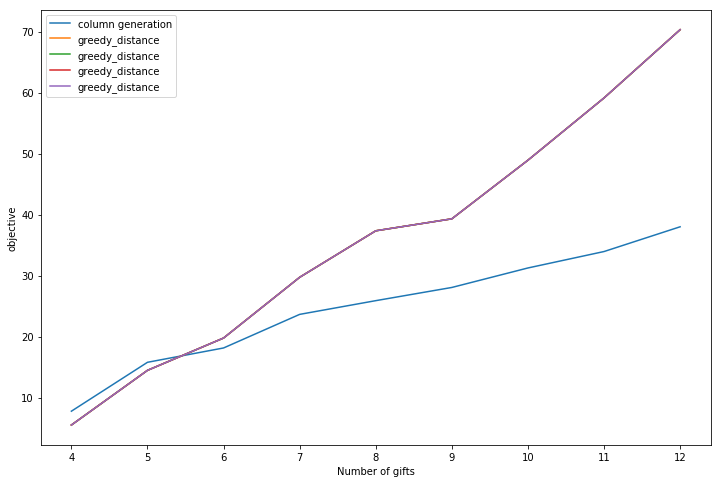

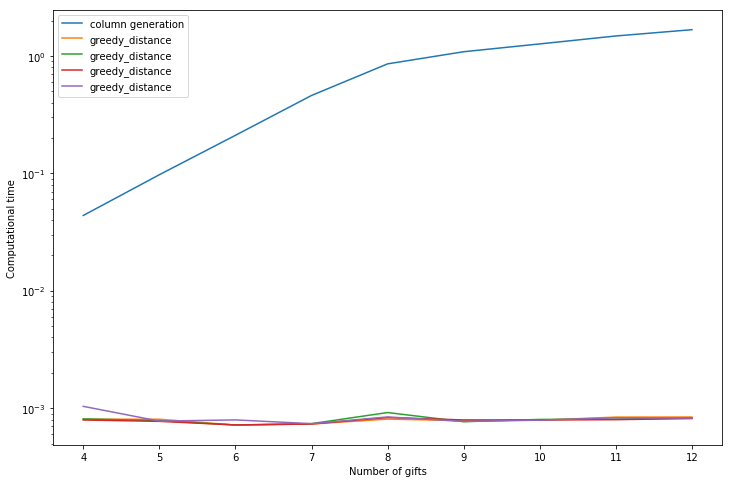

Wall time: 8.08 s


In [36]:
%%time
objective_list, time_list  = test(range(4,13,1), mask_methods=[False, True, True, True, True])

# =======================================================================================================================
# =======================================================================================================================
# =======================================================================================================================
# =======================================================================================================================
# =======================================================================================================================
# =======================================================================================================================
# =======================================================================================================================

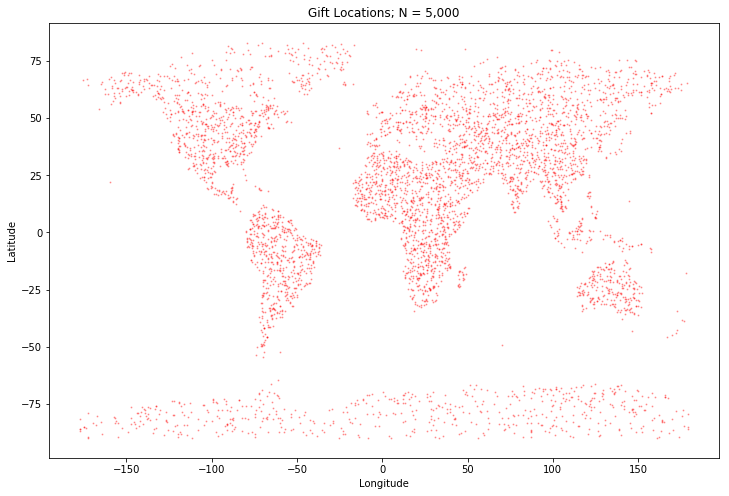

In [4]:
# distribution for considered subset of gifts !!DOESN'T WORK BECAUSE OF dist matrix calculation!!

gift_num = 5000
Problem(gifts[:gift_num], sample_submission[sample_submission.GiftId<=gift_num]).distribution()

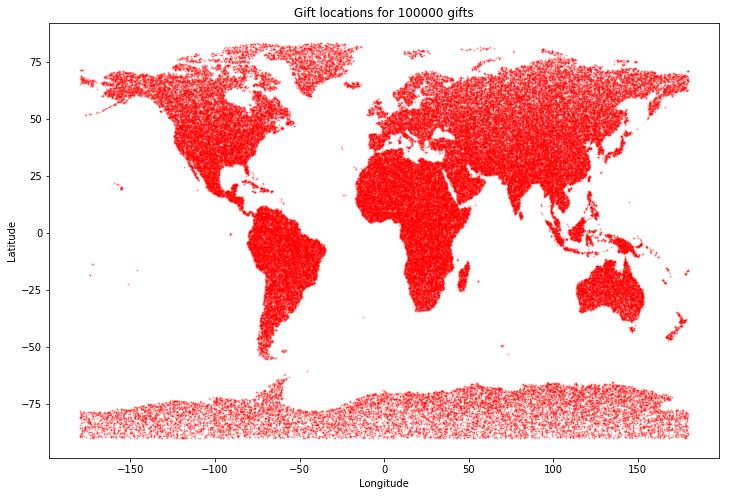

In [5]:
gifts.plot.scatter('Longitude', 'Latitude', alpha=0.3, s=1, color='red',figsize = (12,8))
plt.title('Gift locations for ' + str(len(gifts)) + " gifts")
plt.show()
plt.savefig('All_gift_locations.png')

In [6]:
class Color(object):
    def __init__(self, r, g, b):
        self._color = (r,g,b)

    def get_tuple(self):
        return self._color

    def get_str(self):
        return "#%02X%02X%02X" % self._color

    def __str__(self):
        return self.get_str()

#     def get_YUV(self):


In [8]:
def visualise(solution, coor):

        
# #     # Gift locations
# # #     plt.figure()
# #     self.df_data.plot.scatter('Longitude', 'Latitude', alpha=0.3, s=1, color='red',figsize = (12,8))
# #     plt.title('Gift Locations; N = {:,}'.format(len(self.df_data)))
# #     plt.show()
# #     plt.savefig('All_gift_locations.png')   
    
#     size = len(solution["TripId"])
#     ad_m = np.zeros([size,size])
    
# #     curr = size+1
# #     generate adjecent matrix
#     for i in range(size):
# #         curr = size+1
# #         print(solution["GiftId"][i]-1)
#         ad_m[i,solution["GiftId"][i]-1] = 1
# #         curr = 
#     ad_m = ad_m + ad_m.T    
# #     nm = x.shape[0]
#     plt.figure(figsize = (15,10))
# #     ad_m = np.zeros( [len(solution["TripId"]),len(solution["TripId"])] )
#     G = nx.from_numpy_matrix(ad_m, create_using = nx.MultiDiGraph())
    
#     nx.draw_networkx_nodes(G, coor, node_size=200)

# # #     x_dic and v_dic for edges and vertex dictionaries
# #     x_dic = {}    
    
# #     for i in range(nm):
# #         for j in range(nm):
            
# #             if(x[i,j]!=0):
                
# #                 x_dic[(i,j)] = x[i,j]  
                
#     v_dic = {}
# #     print(solution.TripId[4])
#     for i in range(len(solution["TripId"])):
#         v_dic[i] = i+1#str(int(solution.GiftId[i]))
        
#     nx.draw_networkx_edges(G, coor,G.edges())
# #     nx.draw_networkx_edge_labels(G, new_coor,x_dic)
#     nx.draw_networkx_labels(G ,coor, v_dic)  
    
    G=nx.DiGraph(name="buba")
    num_of_trips = len(solution["TripId"].unique())
    tmp1 = np.array(solution["TripId"])
#     print(num_of_trips)
    routes = []
    for i in range(1,num_of_trips+1):
        tmp = solution["GiftId"][solution["TripId"] == i] 
        tmp = np.concatenate( (np.array([0]),tmp)) 
        tmp = np.concatenate( (tmp, np.array([0])))
#         print(tmp1)
        if len(tmp)!= 0: routes.append(tmp)
#     print(routes)
    
    
    # print(routes)
    edges = []
    for r in routes:
        route_edges = [(r[n],r[n+1]) for n in range(len(r)-1)]
        G.add_nodes_from(r)
        G.add_edges_from(route_edges)
        edges.append(route_edges)

    print("Graph has %d nodes with %d edges" %(G.number_of_nodes(),    
    G.number_of_edges()))

    pos = nx.spring_layout(G)
#     print(pos[1])
    newpos = {}
    for i in range(len(solution["GiftId"])+2):
        newpos[i] = coordinates[i,:]
    # pos = coordinates
    plt.figure(3,figsize=(15,12)) 
    nx.draw_networkx_nodes(G,pos=newpos, node_size=(2500/len(solution["GiftId"]))**1.3)
    nx.draw_networkx_labels(G,pos=newpos, font_size=(50**1.5/len(solution["GiftId"])**0.9))
    
    colors = np.zeros([num_of_trips,3  ])
    
    for i in range(num_of_trips):
        
        colors[i,:] = np.random.randint(200, size=(1, 3))#np.random.rand(1,3) *200
    
#     print(colors)
    
    linewidths = [np.sqrt(50/len(solution["GiftId"]))]*num_of_trips
    
    
    edge_labels = {}
    
    for i in range(len(solution["TripId"])):
        edge_labels[i] = str(tmp1[i])
    print(edge_labels)
    if len(colors) == 1:
        for ctr, edgelist in enumerate(edges):

            nx.draw_networkx_edges(G,pos=newpos,edgelist=edgelist, width=linewidths[ctr])  #edge_color = colors[ctr],
#              
#             nx.draw_networkx_edge_labels(G,pos=newpos,edge_labels, label_pos=0.5)
#     nx.draw_networkx_labels(G ,new_coor, v_dic)

        plt.savefig('this.png')
        
    else:
        for ctr, edgelist in enumerate(edges):
#             print(ctr)
            nx.draw_networkx_edges(G,pos=newpos,edge_labels = solution["TripId"], label_pos=0.5,edge_color = str(Color(colors[ctr,0], colors[ctr,1], colors[ctr,2])),\
                                   edgelist=edgelist, width=linewidths[ctr], arrows=True, arrow_width=0.4, )  #edge_color = colors[ctr],
        plt.savefig('this.png')     
            




Graph has 51 nodes with 51 edges
{0: '1', 1: '1', 2: '1', 3: '1', 4: '1', 5: '1', 6: '1', 7: '1', 8: '1', 9: '1', 10: '1', 11: '1', 12: '1', 13: '1', 14: '1', 15: '1', 16: '1', 17: '1', 18: '1', 19: '1', 20: '1', 21: '1', 22: '1', 23: '1', 24: '1', 25: '1', 26: '1', 27: '1', 28: '1', 29: '1', 30: '1', 31: '1', 32: '1', 33: '1', 34: '1', 35: '1', 36: '1', 37: '1', 38: '1', 39: '1', 40: '1', 41: '1', 42: '1', 43: '1', 44: '1', 45: '1', 46: '1', 47: '1', 48: '1', 49: '1'}


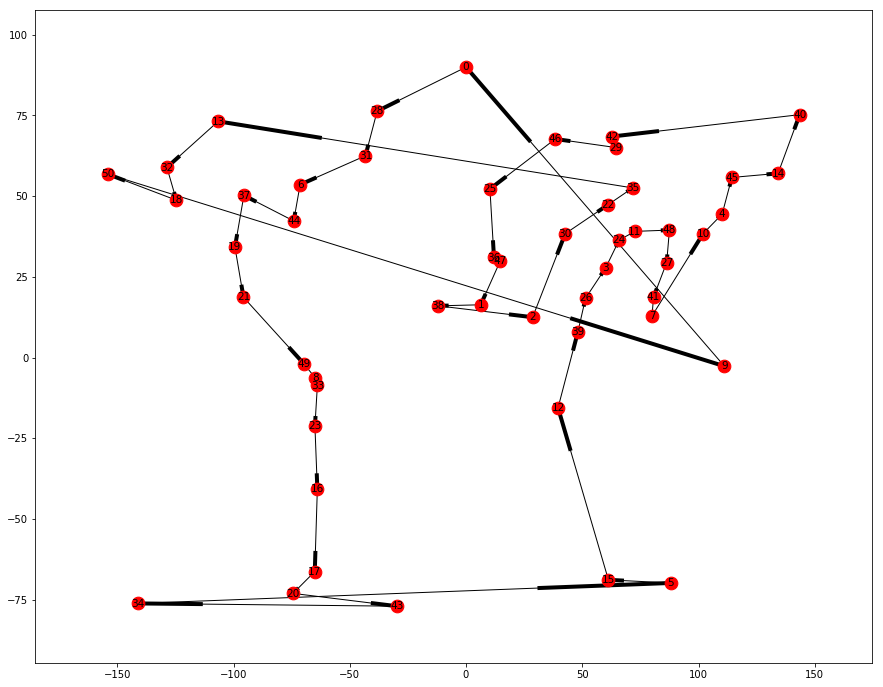

In [9]:
gifts = pd.read_csv('gifts.csv')
sample_submission= pd.read_csv('sample_submission.csv') 

gift_num = 50

problem=Problem(gifts[:gift_num], sample_submission[sample_submission.GiftId<=gift_num])
greed_solution = problem.Greedy_solver()
sub_solution = problem.solution


coordinates = np.zeros([len(sub_solution["TripId"])+2,2])
tmp = np.concatenate( (np.array(gifts[:gift_num].Longitude), np.array([0]) ))
coordinates[:,0] = np.concatenate( (np.array([0]) , tmp ) )
tmp = np.concatenate( (np.array(gifts[:gift_num].Latitude), np.array([90])))
coordinates[:,1] = np.concatenate( (np.array([90]) , tmp ) )

visualise(greed_solution, coordinates)



Graph has 50 nodes with 99 edges
{0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9', 10: '10', 11: '11', 12: '12', 13: '13', 14: '14', 15: '15', 16: '16', 17: '17', 18: '18', 19: '19', 20: '20', 21: '21', 22: '22', 23: '23', 24: '24', 25: '25', 26: '26', 27: '27', 28: '28', 29: '29', 30: '30', 31: '31', 32: '32', 33: '33', 34: '34', 35: '35', 36: '36', 37: '37', 38: '38', 39: '39', 40: '40', 41: '41', 42: '42', 43: '43', 44: '44', 45: '45', 46: '46', 47: '47', 48: '48', 49: '49'}


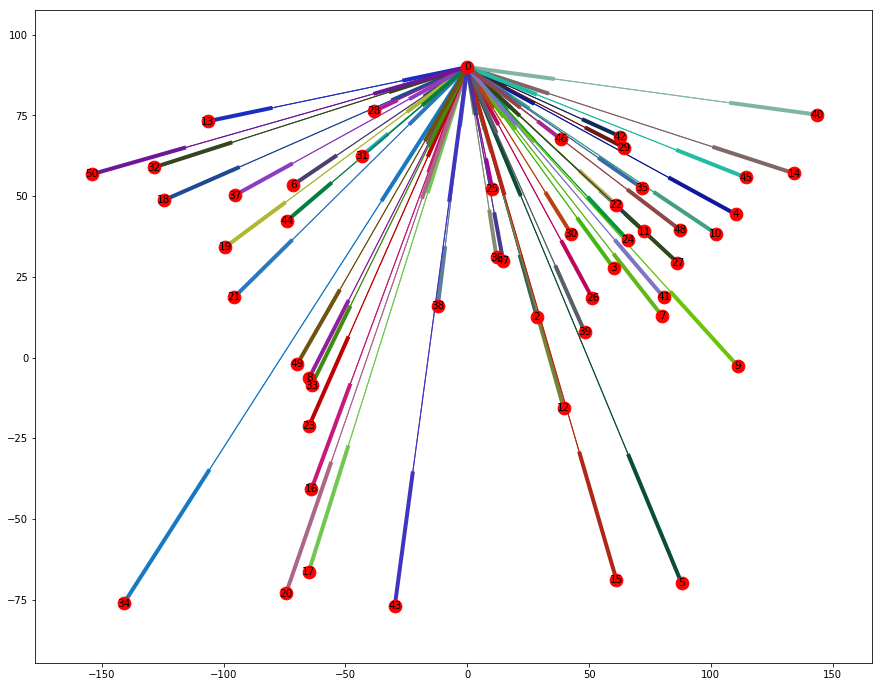

In [10]:
visualise(sub_solution, coordinates)

Graph has 11 nodes with 14 edges
{0: '1', 1: '2', 2: '3', 3: '3', 4: '3', 5: '3', 6: '4', 7: '4', 8: '4', 9: '4'}


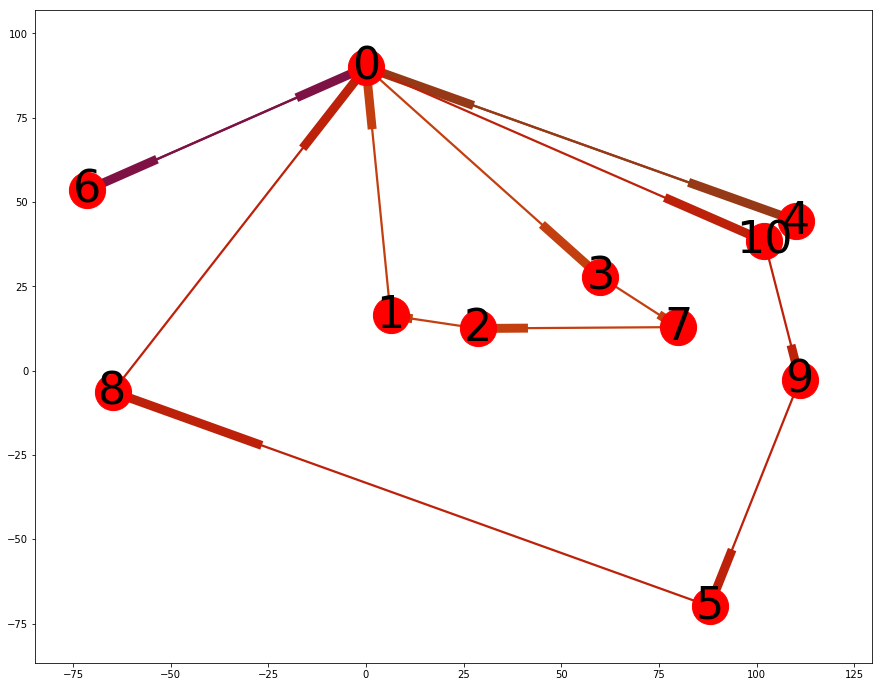

Graph has 11 nodes with 13 edges
{0: '1', 1: '1', 2: '1', 3: '1', 4: '1', 5: '1', 6: '2', 7: '3', 8: '3', 9: '3'}


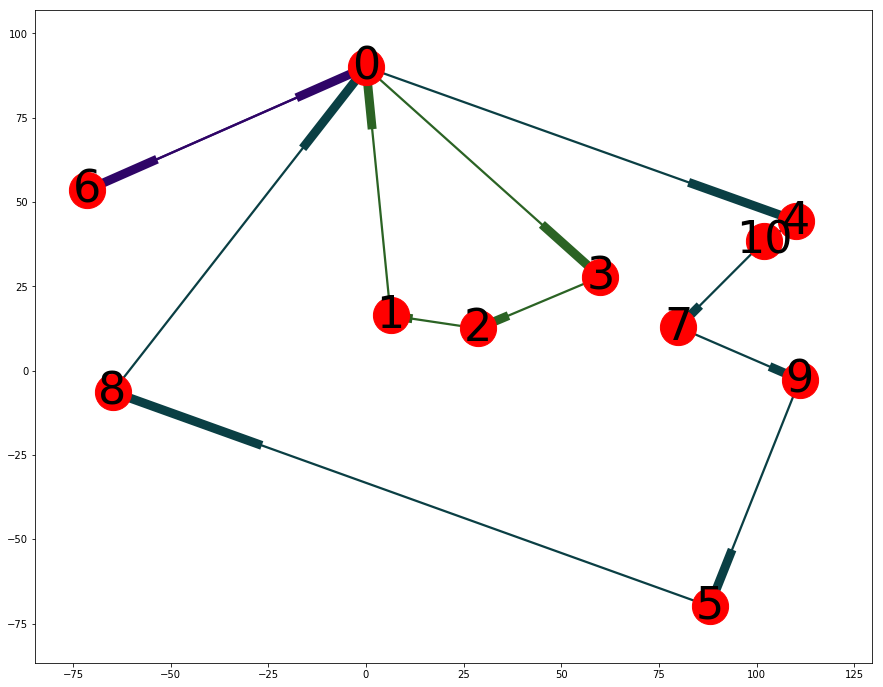

In [19]:
gifts = pd.read_csv('gifts.csv')
cg1_submission= pd.read_csv('column_generation10') 
cg2_submission= pd.read_csv('column_generation20') 
cg3_submission= pd.read_csv('column_generation50') 

sa1_submission= pd.read_csv('sa_10.csv') 
sa2_submission= pd.read_csv('sa_20.csv') 
sa3_submission= pd.read_csv('sa_50.csv') 

cg1_submission["TripId"] += 1
cg2_submission["TripId"] += 1
cg3_submission["TripId"] += 1
    
gift_num = 10



coordinates = np.zeros([len(cg1_submission["TripId"])+2,2])
tmp = np.concatenate( (np.array(gifts[:gift_num].Longitude), np.array([0]) ))
coordinates[:,0] = np.concatenate( (np.array([0]) , tmp ) )
tmp = np.concatenate( (np.array(gifts[:gift_num].Latitude), np.array([90])))
coordinates[:,1] = np.concatenate( (np.array([90]) , tmp ) )



visualise(cg1_submission, coordinates)
plt.show()

visualise(sa1_submission, coordinates)

In [20]:
cg1_submission

,Unnamed: 0,GiftId,TripId
0,0,4,1
1,1,6,2
2,2,3,3
3,3,7,3
4,4,2,3
5,5,1,3
6,6,10,4
7,7,9,4
8,8,5,4
9,9,8,4


Graph has 21 nodes with 33 edges
{0: '1', 1: '2', 2: '3', 3: '4', 4: '5', 5: '6', 6: '7', 7: '8', 8: '9', 9: '10', 10: '11', 11: '12', 12: '12', 13: '12', 14: '13', 15: '13', 16: '13', 17: '13', 18: '13', 19: '13'}


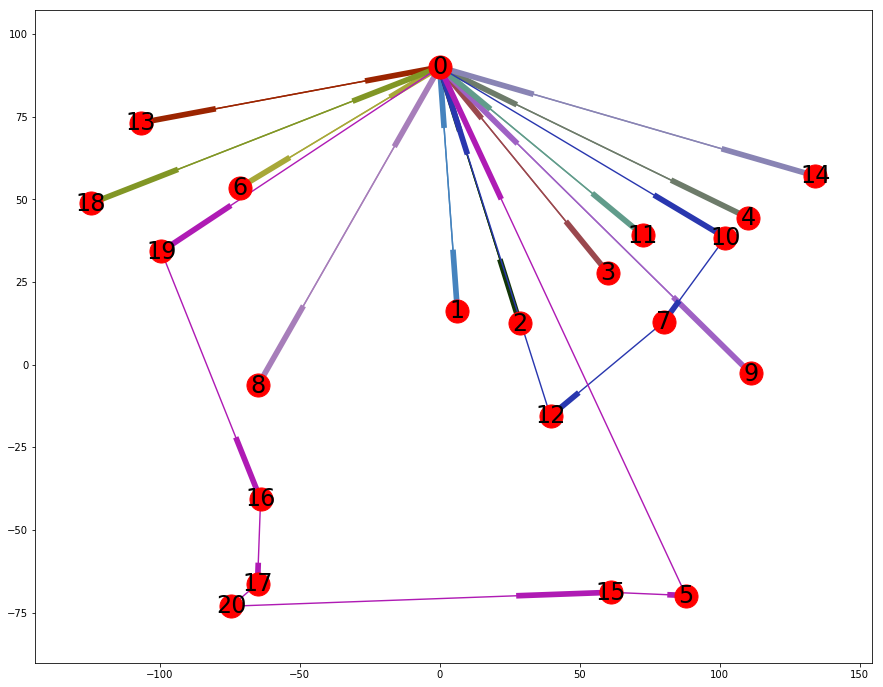

Graph has 21 nodes with 25 edges
{0: '1', 1: '1', 2: '1', 3: '1', 4: '1', 5: '1', 6: '1', 7: '1', 8: '2', 9: '2', 10: '2', 11: '3', 12: '3', 13: '3', 14: '4', 15: '4', 16: '4', 17: '5', 18: '5', 19: '5'}


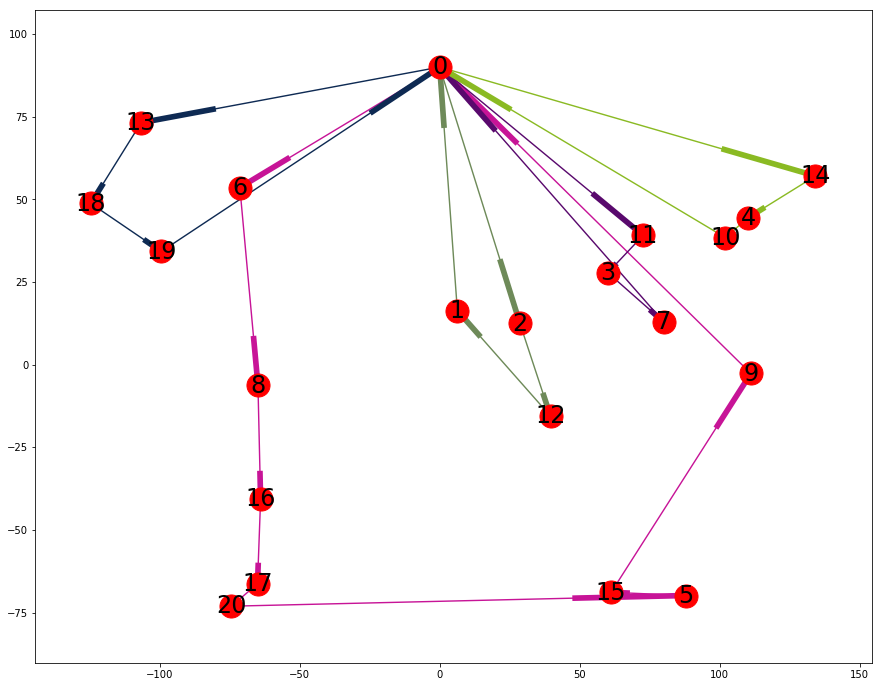

In [21]:
gift_num = 20



coordinates = np.zeros([len(cg2_submission["TripId"])+2,2])
tmp = np.concatenate( (np.array(gifts[:gift_num].Longitude), np.array([0]) ))
coordinates[:,0] = np.concatenate( (np.array([0]) , tmp ) )
tmp = np.concatenate( (np.array(gifts[:gift_num].Latitude), np.array([90])))
coordinates[:,1] = np.concatenate( (np.array([90]) , tmp ) )

visualise(cg2_submission, coordinates)
plt.show()

visualise(sa2_submission, coordinates)

Graph has 51 nodes with 90 edges
{0: '1', 1: '2', 2: '3', 3: '4', 4: '5', 5: '6', 6: '7', 7: '8', 8: '9', 9: '10', 10: '11', 11: '12', 12: '13', 13: '14', 14: '15', 15: '16', 16: '17', 17: '18', 18: '19', 19: '20', 20: '21', 21: '22', 22: '23', 23: '24', 24: '25', 25: '26', 26: '27', 27: '28', 28: '29', 29: '30', 30: '31', 31: '32', 32: '33', 33: '34', 34: '35', 35: '36', 36: '37', 37: '37', 38: '37', 39: '38', 40: '38', 41: '38', 42: '38', 43: '39', 44: '39', 45: '39', 46: '40', 47: '40', 48: '40', 49: '40'}


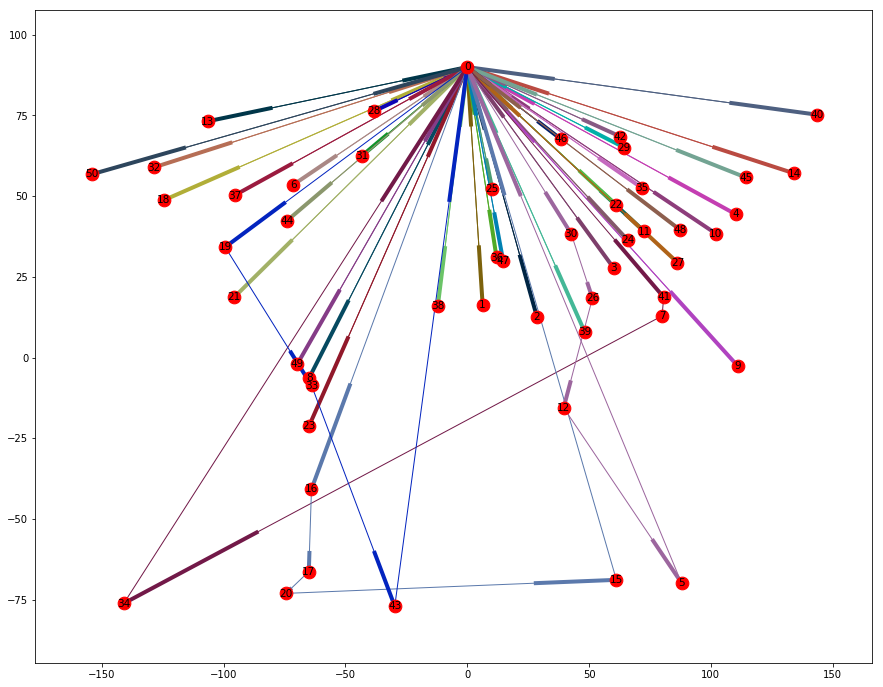

Graph has 51 nodes with 60 edges
{0: '1', 1: '1', 2: '1', 3: '1', 4: '1', 5: '1', 6: '1', 7: '1', 8: '1', 9: '1', 10: '1', 11: '1', 12: '2', 13: '2', 14: '2', 15: '2', 16: '2', 17: '3', 18: '3', 19: '3', 20: '3', 21: '3', 22: '4', 23: '4', 24: '5', 25: '5', 26: '5', 27: '5', 28: '5', 29: '5', 30: '5', 31: '6', 32: '6', 33: '7', 34: '7', 35: '7', 36: '7', 37: '8', 38: '8', 39: '9', 40: '9', 41: '9', 42: '9', 43: '9', 44: '10', 45: '10', 46: '10', 47: '10', 48: '10', 49: '10'}


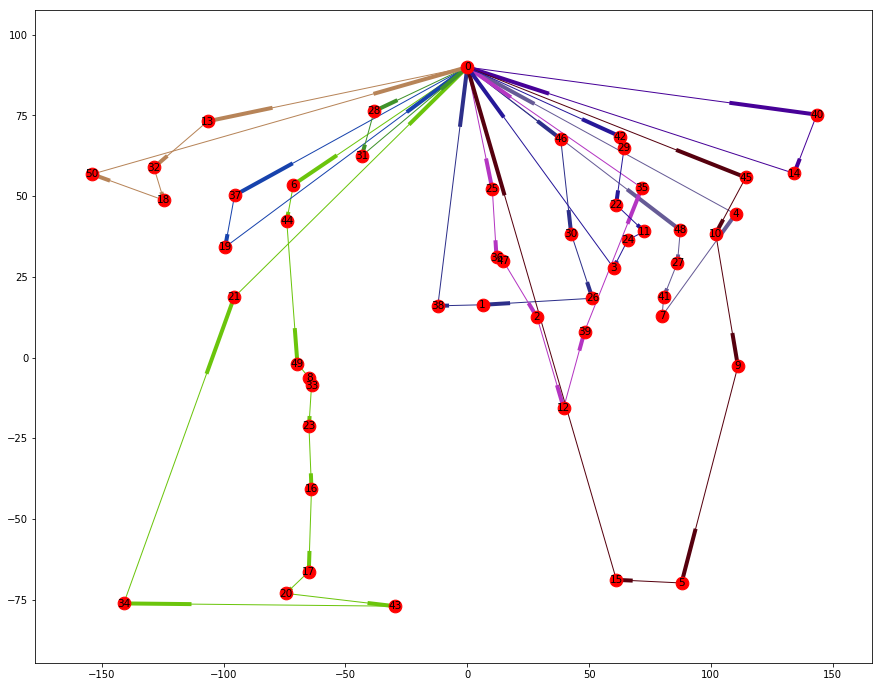

In [22]:
gift_num = 50



coordinates = np.zeros([len(cg3_submission["TripId"])+2,2])
tmp = np.concatenate( (np.array(gifts[:gift_num].Longitude), np.array([0]) ))
coordinates[:,0] = np.concatenate( (np.array([0]) , tmp ) )
tmp = np.concatenate( (np.array(gifts[:gift_num].Latitude), np.array([90])))
coordinates[:,1] = np.concatenate( (np.array([90]) , tmp ) )

visualise(cg3_submission, coordinates)
plt.show()

visualise(sa3_submission, coordinates)

# =======================================================================================================================
# =======================================================================================================================
# =======================================================================================================================
# =======================================================================================================================
# =======================================================================================================================
# =======================================================================================================================
# =======================================================================================================================

In [9]:
# import pandas as pd;
# import numpy as np;
# from haversine import haversine
# from gurobipy import *
# import gurobipy as grb
# from gurobipy import GRB
# import cvxpy as cvx

# class Problem:
    
#     def __init__(self, data, sample_submission=None):
        
#         """
#         input:
        
#         data - данные об исходной проблеме в формате dataframe pandas со столбцами
#         GiftId, Latitude, Longitude, Weight
        
#         sample_submission - начальное решение проблемы. Формат dataframe pandas со столбцами GiftId and TripId.
#         GiftId should be ordered by the order of delivery, and different trips should have different TripIds. 
        
#         """
        
#         self.df_data=data
#         # количество точек, включая полюс 
#         self.N = data.shape[0]+1
#         # вес саней
#         self.weight_sleighs=10
#         # лимит саней
#         self.weight_limit = 1000 
#         # вес подарков плюс сани
#         self.weights=np.asarray(data.Weight)
#         # self.weights=np.append(self.weights, self.weight_sleighs)
    
#         # стартовая позиция (Lat=90, Long=0)
#         # широта, долгота
#         self.lat=np.asarray(data.Latitude)*(np.pi/180.0)
#         self.lat=np.append(self.lat, 90*np.pi/180)
#         self.long=np.asarray(data.Longitude)*(np.pi/180.0)
#         self.long=np.append(self.long,0)
#         self.Earth_radius=6371
        
#         # разница в широте
#         dlat = \
#             np.matlib.repmat(self.lat,self.N,1) - \
#             np.matlib.repmat(self.lat,self.N,1).transpose();
#         # разница в долготе
#         dlong = \
#             np.matlib.repmat(self.long,self.N,1) - \
#             np.matlib.repmat(self.long,self.N,1).transpose();
        
#         # cos широты
#         cos_lat=np.cos(self.lat).reshape(1,self.N)
        
#         # harvesine distance
#         # https://en.wikipedia.org/wiki/Great-circle_distance
#         # расстояние между точками
#         self.dist=self.Earth_radius*2* \
#                  np.arcsin(np.sqrt(np.sin(dlat/2.0)**2 \
#                  +cos_lat*cos_lat.T*np.sin(dlong/2.0)**2))  
    
#         # решение
#         self.solution=sample_submission
    
#         # значение целевой функции
#         self.obj=np.inf
#         # weighted_reindeer_weariness(self.solution)

#     def weighted_onetrip_weariness(self, onetrip): 

#         """
#         input:

#         onetrip - последовательность развоза подарков для одного трипа (с северного полюса и обратно). 
#         формат numpy array в которых содержатся GiftId.GiftId should be ordered by the order of delivery. 

#         output: 

#         obj - значение целевой функции для одного трипа (формат float)

#         """

#         obj_onetrip = 0.0          
#         prev_stop = self.N-1 #начинаем с северного полюса, идем в обратном направлении по маршруту
#         prev_weight = self.weight_sleighs
#         for i in onetrip[::-1]:
#             obj_onetrip += self.dist[prev_stop,i] * prev_weight
#             prev_stop = i
#             prev_weight += self.weights[i]
            
#         if prev_weight > self.weight_limit + self.weight_sleighs:
#             return np.inf

#         # плюс маршрут с северного полюса    
#         obj_onetrip += self.dist[prev_stop,self.N-1] * prev_weight

#         return obj_onetrip
        

#     def objective(self, all_trips):
        
#         """
#         input:
        
#         all_trips - решение исходной проблемы в формате dataframe pandas со столбцами GiftId and TripId.
#         GiftId should be ordered by the order of delivery, and different trips should have different TripIds. 
        
#         output: 
        
#         obj - значение целевой функции (формат float)
        
#         """
        
#         n=all_trips.shape[0]
        
#         uniq_gifts = all_trips.GiftId.unique()
    
#         uniq_trips = all_trips.TripId.unique()

#         obj = 0.0
#         for i in uniq_trips:
#             trip = np.asarray(all_trips[all_trips.TripId==i].GiftId)-1
#             wrw = self.weighted_onetrip_weariness(trip)
#             if wrw == np.inf:
#                 print("One of the sleighs is over the weight limit!")
#                 return np.inf
#             # print('wrw',i, ' ', wrw)
#             obj += wrw
         
#         if n!=len(uniq_gifts):
#             return np.inf

#         return obj/100000
    
#     def solve_knapsack(self, y, n_sol_to_collect=100, gap=0.5, n_var=5, verbose=False, pr=False):
    
#         """
#         input:

#         y - текущее решение дуальной задачи в формате np array длины N -кол-во подарков
        
#         n_sol_to_collect - максимальное число лучших решений задачи о рюкзаке, которое пойдет в output (int)
        
#         gap - Limit the search space by setting a gap for the worst possible solution that will be accepted (float)
        
#         n_var - ограничение на количество переменных равных 1 в задаче о рюкзаке (int)
        
#         verbose - вывод информации о решении gurobi (boolean)
        

#         output: 

#         alpha - массив K лучших целочисленных решений задачи в формате boolean np array N x K, 
#         N - число подарков, K - число лучших решений

#         """

#         try:
#             # Sample data
#             Groundset    = range(self.N-1)
#             objCoef      = y
#             knapsackCoef = self.weights
#             Budget       = self.weight_limit-self.weight_sleighs

#             # Create initial model
#             model = Model("poolsearch")
#             model.setParam(GRB.Param.OutputFlag, verbose)

#             # Create dicts for tupledict.prod() function
#             objCoefDict = dict(zip(Groundset, objCoef))
#             knapsackCoefDict = dict(zip(Groundset, knapsackCoef))

#             # Initialize decision variables for ground set:
#             # x[e] == 1 if element e is chosen
#             Elem = model.addVars(Groundset, vtype=GRB.BINARY, name='El')


#             # Set objective function
#             model.ModelSense = GRB.MAXIMIZE
#             model.setObjective(Elem.prod(objCoefDict))

#             # Constraint: limit total number of elements to be picked to be at most
#             # Budget
#             model.addConstr(Elem.prod(knapsackCoefDict) <= Budget, name='Budget')

#             model.addConstr(grb.quicksum(Elem) <= n_var, name='nonzero var')


#             # Limit how many solutions to collect
#             model.setParam(GRB.Param.PoolSolutions, n_sol_to_collect)
#             # Limit the search space by setting a gap for the worst possible solution that will be accepted
#             model.setParam(GRB.Param.PoolGap, gap)
#             # do a systematic search for the k-best solutions
#             model.setParam(GRB.Param.PoolSearchMode, 2)

#             # save problem
#             # model.write('poolsearch.lp')

#             # Optimize
#             model.optimize()


#             # Status checking
#             status = model.Status
#             if status == GRB.Status.INF_OR_UNBD or \
#                status == GRB.Status.INFEASIBLE  or status == GRB.Status.UNBOUNDED:
#                 print('The model cannot be solved because it is infeasible or unbounded')
#                 sys.exit(1)

#             if status != GRB.Status.OPTIMAL:
#                 print('Optimization was stopped with status ' + str(status))
#                 sys.exit(1)

#             # Print number of solutions stored
#             nSolutions = model.SolCount
#             if pr: print('Number of solutions found: ' + str(nSolutions))

#             alpha=[]
#             for i in range(nSolutions):
#                 model.setParam(GRB.Param.SolutionNumber, i)
#                 alpha.append([True if Elem[e].Xn > .9 else False for e in Groundset])

#             return np.array(alpha)


#         except GurobiError as e:
#             print('Gurobi error ' + str(e.errno) + ": " + str(e.message))

#         except AttributeError as e:
#             print('Encountered an attribute error: ' + str(e))
            
            
# #     def solve_dual(self, n_sol_to_collect=100, gap=0.5, pr=False):
        
# #         """
# #         input:
        
# #         n_sol_to_collect - максимальное число лучших решений задачи о рюкзаке, которое пойдет в output (int)
        
# #         gap - Limit the search space by setting a gap for the worst possible solution that will be accepted (float)
            

# #         output: 

# #         A - транспанированная матрица ограничений для первичной задачи (np array)
        
# #         wtw -  лист коэффициентов для целевой функции первичной задачи (np array)
        
# #         wtw_solution_list - Cоответствуют коэффициентам wtw. Решения - последовательность развоза подарков для одного трипа, 
# #         в которых содержатся GiftId. GiftId should be ordered by the order of delivery.
        
      
# #         """
    
        
# #         print('dual problem')
        
        
# #         # начальные ограничения - для каждого подарка оцениваем трип в котором доставлеям только этот подарок - 
# #         # расстояние до подарка на вес и от подарка на вес саней
        
# #         wtw=[]
# #         wtw_solution_list=[]

# #         for i in range(self.N-1):
# #             wtw.append(self.dist[i, self.N-1]*(self.weights[i]+2*self.weight_sleighs))
# #             wtw_solution_list.append(np.array([i]))

# #         wtw=np.array(wtw)
# #         if pr: print('initial wtw', wtw)
# #         if pr: print('wtw_solution_list', wtw_solution_list)

# #         # Create two scalar optimization variables.
# #         y = cvx.Variable(self.N-1)

# #         A = np.eye(self.N-1, dtype=int)
# #         b = wtw

# #         # Create constraints.
# #         constraints = [A*y <= b,
# #                        y >= 0]

# #         # Form objective.
# #         obj = cvx.Maximize(sum(y))

# #         T=True
# #         iteration=0
# #         while T: 
# #             iteration+=1
# #             T=False

# #             # Form and solve problem.
# #             prob = cvx.Problem(obj, constraints)
# #             prob.solve()  # Returns the optimal value.

# #             # получаем решение дуальной проблемы
# #             y_solution=np.array(y.value).flatten()
# #             if pr: print('y_solution', y_solution)

# #             # находим трип, который предположительно будет нарушать ограничения дуальной задачи
# #             for n_var in range(self.N-1, 2,-1):

# #                 if pr: print('n_var', n_var)
# #                 alpha=self.solve_knapsack(y_solution, n_sol_to_collect=n_sol_to_collect, gap=gap, n_var=n_var)
# #                 if pr: print(alpha)

# #                 for a in alpha:

# #                     # получаем правую часть неравенства дуальной задачи для нашей альфа
# #                     if pr: print('a', a)
# #                     if pr: print('sum_a', sum(a))
# #                     if sum(a)<2: break
# #                     wtw_solution=self.solve_onetrip_greedy(a)
# #                     if pr: print('wtw_solution', wtw_solution)
# #                     wtw_objective=self.weighted_onetrip_weariness(wtw_solution)

# #                     if pr: print('wtw_objective', wtw_objective)

# #                     if a@y_solution>wtw_objective+0.1:
# #                         print('добавляем a', a)
# #                         if pr: print('y_solution', y_solution)
# #                         if pr: print('добавляем ограничение, разница = ', a@y_solution-wtw_objective)
# #                         A=np.append(A,[a], axis=0)
# #                         if pr: print(A)
# #                         wtw=np.append(wtw,wtw_objective)
# #                         wtw_solution_list.append(wtw_solution)
# #                         if pr: print('wtw_objective', wtw_objective)
# #                         if pr: print('wtw_solution_list', wtw_solution_list)

# #                         constraints.append(a*y <=wtw_objective)
# #                         T=True
# #                         break
                        
                        
# #                 # возможно не надо
# #                 if T: break

# #         if pr: print(A, wtw, wtw_solution_list)
        
# #         print('A', A)
# #         print('iteration ', iteration)
# #         print("status:", prob.status) 
# #         print("optimal value", prob.value) 
# #         print("optimal var", y_solution) 

# #         return A, wtw, wtw_solution_list
    
#     def solve_prime(self, n_sol_to_collect=100, gap=0.5, pr=False, verbose=True):
       
#         """
#         input:
        
#         n_sol_to_collect - максимальное число лучших решений задачи о рюкзаке, которое пойдет в output (int)
        
#         gap - Limit the search space by setting a gap for the worst possible solution that will be accepted (float)
      
#         """
    
        
#         A, wtw, wtw_solution_list = self.solve_dual(n_sol_to_collect=n_sol_to_collect, gap=gap)

#         if pr: print('wtw', wtw)

#         print('\nprime problem')

#         n=len(wtw)

#         m = grb.Model()

#         x = []
#         for i_f in range(n):
#             x.append(m.addVar(vtype=GRB.BINARY))

#         for i_c in range(A.shape[1]):  
#             constr_summands = [ -A[i_r][i_c]*x[i_r] for i_r in range(A.shape[0])]
#             m.addConstr(sum(constr_summands), GRB.LESS_EQUAL, -1)

#         m.modelSense = GRB.MINIMIZE

#         m.update()

#         obj_summands = []
#         for i in range(n): 
#             obj_summands.append(wtw[i]*x[i])

#         m.setObjective(grb.quicksum(obj_summands))

#         m.setParam(GRB.Param.OutputFlag, verbose)
#         m.optimize()
#         print('Status', m.Status)
#         print('Status', m.Status)

#         x_solution=np.array([x[e].Xn for e in range(n)])

#         print('x_solution', x_solution)

#         if pr: print(wtw_solution_list)
            
#         # формируем решение в форме submission
#         gifts=np.arange(1, self.N)
#         TripId=0
#         d = {'GiftId': [], 'TripId': []}
#         for i_x, sol in enumerate(x_solution):
#             if sol==1:
#                 d['GiftId'].extend(wtw_solution_list[i_x]+1)
#                 d['TripId'].extend([TripId]*len(wtw_solution_list[i_x]))
#                 if pr: print('GiftId',d['GiftId'])
#                 if pr: print('TripId', d['TripId'])
#                 TripId+=1

#         solution = pd.DataFrame(data=d)

#         self.solution=solution

#         uniq_gifts = self.solution.GiftId.unique()

#         if (self.N-1)==len(uniq_gifts):
#             self.obj=self.objective(self.solution)
#         else: self.obj=np.inf
 
#     def solve_onetrip_greedy(self, knapsack, pr=False):

#         """
#         input:

#         knapsack - целочисленное решение задачи о рюкзаке в формате boolean np array

#         output: 

#         solution - решение задачи развоза подарков для одного трипа в формате boolean np array - 
#         в которых содержатся GiftId. GiftId should be ordered by the order of delivery. 

#         """

#         if pr: print('knapsack', knapsack)
#         index=np.where(knapsack==True)[0]
#         if pr: print('subproblem index', index)
#         if pr: print('length subproblen', len(index))
#         subproblem=Problem(self.df_data.iloc[knapsack], None)

#         df_solution=subproblem.Greedy_solver()
#         subproblem_solution=np.array(df_solution['GiftId'])-1
#         if pr: print('subproblem_solution', subproblem_solution)

#         solution=index[subproblem_solution]

#         return solution

      
#     def Randomize_solver(self):
        
#         """
        
#         output:
        
#         rand_sol - решение исходной проблемы в формате dataframe pandas со столбцами GiftId and TripId.
        
        
#         """

#         gift_weights = self.weights.copy()

#         # a list of trip numbers
#         rand_trips = []
    
#         # a list of gifts ids
#         rand_gifts = []

#         i = 0
#         curr_sleight_weight = 0.
#         choices = np.linspace(0,self.N-1,self.N)
#         # print(choices)
#         # the first point - destination is North poles
#         current_gift_destination = self.N-1
        
#         while len(choices) != 1:
#             # print("len ", len(choices))
#             # tmp1 - array of destination of gifts that are the nearest to North pole
#             random_gift_destinations = random.choice(choices[:-1])

#             current_gift_destination = int(random_gift_destinations)
    
#             # add weight to sleight [there no need to calculate cost because of not usage]
#             curr_sleight_weight += gift_weights[current_gift_destination]

#             if curr_sleight_weight < (self.weight_limit-self.weight_sleighs):

#                 index = np.where(choices == current_gift_destination)[0]
#                 choices = np.delete(choices, index)
#                 rand_gifts.append(current_gift_destination)
#                 rand_trips.append(i)
                
#             else:
#                 i += 1

#                 curr_sleight_weight = 0.
#                 current_gift_destination = self.N-1

            
#         # convertation into submision format
#         rand_sol = pd.DataFrame({'GiftId':rand_gifts, 'TripId':rand_trips})

#         return rand_sol+1
    
#     def Greedy_solver(self):
        
#         """
        
#         output:
        
#         greed_solution - решение исходной проблемы в формате dataframe pandas со столбцами GiftId and TripId.
        
        
#         """
#         # copy the distances in order to change them
#         distances = self.dist.copy()
#         gift_weights = self.weights.copy()
        
#         # make bound for interuptiong the process of finding the trips
#         bound = 1e20
        
    
#         for i in range(distances.shape[0]):
#             distances[i,i] = bound
    
#         # a list of trip numbers
#         greed_trips = []
    
#         # a list of gifts ids
#         greed_gifts = []
    
        
#         i = 0
#         curr_sleight_weight = 0.
        
#         # the first point - destination is North poles
#         current_gift_destination = self.N-1
        
#         while distances[:-1,:-1].min() < bound/2.:
            
            
#             # tmp1 - array of destination of gifts that are the nearest to North pole
#             nearest_gift_destinations = np.where(distances[:-1, current_gift_destination] == \
#                                                  distances[:-1, current_gift_destination].min())[0][0]


#             current_gift_destination = nearest_gift_destinations
                 
#             # current_gift_destination = giftid
#             # add weight to sleight [there no need to calculate cost because of not usage]
#             curr_sleight_weight += gift_weights[current_gift_destination]
        
#             if curr_sleight_weight < (self.weight_limit-self.weight_sleighs):
                
#                 # if current weight is small enough we put the bound for current point - gift destination = giftid
#                 distances[current_gift_destination, :] =  bound 
#                 # update the set of gifts id f fot current track
#                 greed_gifts.append(current_gift_destination)
#                 greed_trips.append(i)
                
#             else:
                
#                 # if we take more gifts then just consider new trip that begins with North pole and 0 weight
#                 i += 1
#                 curr_sleight_weight = 0.
#                 current_gift_destination = self.N-1
#                 # del greed_trips[-1]

           
                
            
#         # convertation into submision format
#         greed_solution = pd.DataFrame({'GiftId':greed_gifts, 'TripId':greed_trips})
#         # print(greed_gifts)
        
#         return greed_solution+1

#     def Greedy_solver2(self):
        
#         """
        
#         output:
        
#         greed_solution - решение исходной проблемы в формате dataframe pandas со столбцами GiftId and TripId.
        
        
#         """
#         #       copy the distances in order to change them
#         distances = self.dist.copy()
#         gift_weights = self.weights.copy()
        
#         #       make bound for interuptiong the process of finding the trips
#         bound = 1e20
        
    
#         for i in range(distances.shape[0]):
#             distances[i,i] = bound
    
#         #       a list of trip numbers
#         greed_trips = []
    
#         #       a list of gifts ids
#         greed_gifts = []
    
        
#         i = 0
#         curr_sleight_weight = 0.
#         current_trip_distance = 0.
#         #         the first point - destination is North poles
#         current_gift_destination = self.N-1
        
#         while distances[:-1,:-1].min() < bound/2.:
            
            
#             # nearest_gift_destinations - array of destination of gifts that are the nearest to North pole 
#             current_destinations_variety = distances[:-1, current_gift_destination] + 0.*current_trip_distance
#             loc_obj_func_inonetrip = current_destinations_variety/gift_weights
#             nearest_gift_destinations = np.where(loc_obj_func_inonetrip == \
#                                                  loc_obj_func_inonetrip.min())[0][0]
            
#             #             update the trip distance
#             current_trip_distance += distances[nearest_gift_destinations, current_gift_destination]
   
            
#             current_gift_destination = nearest_gift_destinations
            
        
#             #           current_gift_destination = giftid
#             #           add weight to sleight [there no need to calculate cost because of not usage]
#             curr_sleight_weight += gift_weights[current_gift_destination]
        
#             if curr_sleight_weight < (self.weight_limit-self.weight_sleighs):
                
#                 # if current weight is small enough we put the bound for current point - gift destination = giftid
#                 distances[current_gift_destination, :] =  bound 
#                 # update the set of gifts id f fot current track
#                 greed_gifts.append(current_gift_destination)
#                 greed_trips.append(i)
#             else:
                
#                 # if we take more gifts then just consider new trip that begins with North pole and 0 weight
#                 i += 1
#                 curr_sleight_weight = 0.
#                 current_trip_distance = 0.
#                 current_gift_destination = self.N-1
      
#         # convertation into submision format
#         greed_solution = pd.DataFrame({'GiftId':greed_gifts, 'TripId':greed_trips})
        
#         return greed_solution+1
    
#     def Greedy_solver2_test(self):
        
#         """
        
#         output:
        
#         greed_solution - решение исходной проблемы в формате dataframe pandas со столбцами GiftId and TripId.
        
        
#         """
#         #       copy the distances in order to change them
#         distances = self.dist.copy()
#         gift_weights = self.weights.copy()
        
#         #       make bound for interuptiong the process of finding the trips
#         bound = np.inf
        
    
#         for i in range(distances.shape[0]):
#             distances[i,i] = bound
    
#         #       a list of trip numbers
#         greed_trips = []
    
#         #       a list of gifts ids
#         greed_gifts = []
    
        
#         i = 0
#         curr_sleight_weight = 0.
#         current_trip_distance = 0.
#         #         the first point - destination is North poles
#         current_gift_destination = self.N-1
        
#         while distances[:-1,:-1].min() < bound/2.:
            
            
#             # nearest_gift_destinations - array of destination of gifts that are the nearest to North pole 
#             current_destinations_variety = distances[:-1, current_gift_destination] + 0.*current_trip_distance
#             loc_obj_func_inonetrip = gift_weights/current_destinations_variety
            
#             for i in range(loc_obj_func_inonetrip.shape[0]):
#                 if  loc_obj_func_inonetrip[i] == 0.0: loc_obj_func_inonetrip[i] = np.inf
                
#             nearest_gift_destinations = np.where(loc_obj_func_inonetrip == \
#                                                  loc_obj_func_inonetrip.min())[0][0]
            
#             #             update the trip distance
#             current_trip_distance += distances[nearest_gift_destinations, current_gift_destination]
   
            
#             current_gift_destination = nearest_gift_destinations
            
        
#             #           current_gift_destination = giftid
#             #           add weight to sleight [there no need to calculate cost because of not usage]
#             curr_sleight_weight += gift_weights[current_gift_destination]
        
#             if curr_sleight_weight < (self.weight_limit-self.weight_sleighs):
                
#                 # if current weight is small enough we put the bound for current point - gift destination = giftid
#                 distances[current_gift_destination, :] =  bound 
#                 # update the set of gifts id f fot current track
#                 greed_gifts.append(current_gift_destination)
#                 greed_trips.append(i)
#             else:
                
#                 # if we take more gifts then just consider new trip that begins with North pole and 0 weight
#                 i += 1
#                 curr_sleight_weight = 0.
#                 current_trip_distance = 0.
#                 current_gift_destination = self.N-1
      
#         # convertation into submision format
#         greed_solution = pd.DataFrame({'GiftId':greed_gifts, 'TripId':greed_trips})
        
#         return greed_solution+1
    
#     def Greedy_solver3(self):
        
#         """
        
#         output:
        
#         greed_solution - решение исходной проблемы в формате dataframe pandas со столбцами GiftId and TripId.
        
        
#         """
#         #       copy the distances in order to change them
#         distances = self.dist.copy()
#         gift_weights = self.weights.copy()
        
#         #       make bound for interuptiong the process of finding the trips
#         bound = 1e20
        
    
#         for i in range(distances.shape[0]):
#             distances[i,i] = bound
    
#         #       a list of trip numbers
#         greed_trips = []
    
#         #       a list of gifts ids
#         greed_gifts = []
    
        
#         i = 0
#         curr_sleight_weight = 0.
#         current_trip_distance = 0.
#         #         the first point - destination is North poles
#         current_gift_destination = self.N-1
        
#         while distances[:-1,:-1].min() < bound/2.:
            
            
#             # nearest_gift_destinations - array of destination of gifts that are the nearest to North pole 
#             current_destinations_variety = distances[:-1, current_gift_destination] + current_trip_distance
#             loc_obj_func_inonetrip = current_destinations_variety*gift_weights
#             nearest_gift_destinations = np.where(loc_obj_func_inonetrip == \
#                                                  loc_obj_func_inonetrip.min())[0][0]
            
#             #             update the trip distance
#             current_trip_distance += distances[nearest_gift_destinations, current_gift_destination]
   
            
#             current_gift_destination = nearest_gift_destinations
            
        
#             #           current_gift_destination = giftid
#             #           add weight to sleight [there no need to calculate cost because of not usage]
#             curr_sleight_weight += gift_weights[current_gift_destination]
        
#             if curr_sleight_weight < (self.weight_limit-self.weight_sleighs):
                
#                 # if current weight is small enough we put the bound for current point - gift destination = giftid
#                 distances[current_gift_destination, :] =  bound 
#                 # update the set of gifts id f fot current track
#                 greed_gifts.append(current_gift_destination)
#                 greed_trips.append(i)
#             else:
                
#                 # if we take more gifts then just consider new trip that begins with North pole and 0 weight
#                 i += 1
#                 curr_sleight_weight = 0.
#                 current_trip_distance = 0.
#                 current_gift_destination = self.N-1
      
#         # convertation into submision format
#         greed_solution = pd.DataFrame({'GiftId':greed_gifts, 'TripId':greed_trips})
        
#         return greed_solution+1
    
    
#     def Greedy_solver3_test(self):
        
#         """
        
#         output:
        
#         greed_solution - решение исходной проблемы в формате dataframe pandas со столбцами GiftId and TripId.
        
        
#         """
#         #       copy the distances in order to change them
#         distances = self.dist.copy()
#         gift_weights = self.weights.copy()
        
#         #       make bound for interuptiong the process of finding the trips
#         bound = -1e10
        
    
#         for i in range(distances.shape[0]):
#             distances[i,i] = bound
    
#         #       a list of trip numbers
#         greed_trips = []
    
#         #       a list of gifts ids
#         greed_gifts = []
    
        
#         i = 0
#         curr_sleight_weight = 0.
#         current_trip_distance = 0.
#         #         the first point - destination is North poles
#         current_gift_destination = self.N-1
        
#         while distances[:-1,:-1].max() > 0.:
            
            
#             # nearest_gift_destinations - array of destination of gifts that are the nearest to North pole 
#             current_destinations_variety = distances[:-1, current_gift_destination] + current_trip_distance
#             loc_obj_func_inonetrip = current_destinations_variety*gift_weights
#             nearest_gift_destinations = np.where(loc_obj_func_inonetrip == \
#                                                  loc_obj_func_inonetrip.max())[0][0]
            
#             #             update the trip distance
#             current_trip_distance += distances[nearest_gift_destinations, current_gift_destination]
   
            
#             current_gift_destination = nearest_gift_destinations
            
        
#             #           current_gift_destination = giftid
#             #           add weight to sleight [there no need to calculate cost because of not usage]
#             curr_sleight_weight += gift_weights[current_gift_destination]
        
#             if curr_sleight_weight < (self.weight_limit-self.weight_sleighs):
                
#                 # if current weight is small enough we put the bound for current point - gift destination = giftid
#                 distances[current_gift_destination, :] =  bound 
#                 # update the set of gifts id f fot current track
#                 greed_gifts.append(current_gift_destination)
#                 greed_trips.append(i)
#             else:
                
#                 # if we take more gifts then just consider new trip that begins with North pole and 0 weight
#                 i += 1
#                 curr_sleight_weight = 0.
#                 current_trip_distance = 0.
#                 current_gift_destination = self.N-1
      
#         # convertation into submision format
#         greed_solution = pd.DataFrame({'GiftId':greed_gifts, 'TripId':greed_trips})
        
#         return greed_solution+1
    
#     def distribution(self):
        
#         # Gift locations
# #         plt.figure()
#         self.df_data.plot.scatter('Longitude', 'Latitude', alpha=0.3, s=1, color='red',figsize = (12,8))
#         plt.title('Gift Locations; N = {:,}'.format(len(self.df_data)))
#         plt.show()
#         plt.savefig('All_gift_locations.png')
        
    

In [10]:
# gift_num = 1000
# problem=Problem(gifts[:gift_num], sample_submission[sample_submission.GiftId<=gift_num])

# greed3t_time_start = time.clock()
# greed3t_solution = problem.Greedy_solver2_test()
# greed3t_time_elapsed = (time.clock() - greed3t_time_start)

# problem.objective(greed3t_solution)

In [11]:
def test(range_gift_num, mask_methods=[True]*5, 
         labels=['column generation', 'greedy_distance', 'greedy_wdistance', 'one_gift_one_trip_solver', 'random']):
    
    time_list=[]
    objective_list=[]
    
    for  gift_num in range_gift_num:
        
        # print('gift_num', gift_num)

        problem=Problem(gifts[:gift_num], None)
        
        
        def column_generation(): 
            return problem.solve_prime(n_sol_to_collect=10, gap=0.1)
        
        methods=np.array([column_generation, problem.Greedy_solver, problem.Greedy_solver_deep, 
                          problem.one_gift_one_trip_solver, problem.Randomize_solver])
        methods=methods[mask_methods]
        t=one_test(problem, methods)
        objective_list.append(t[0])
        time_list.append(t[1])
        
    time_list, objective_list=np.array(time_list), np.array(objective_list)
    
    # objective
    plt.figure(figsize = (12,8))
    
    for i, m_obj in enumerate(objective_list.T):
        plt.plot(list(range_gift_num), m_obj, label = labels[i])
    
    plt.xlabel("Number of gifts")
    plt.ylabel("objective")
    plt.legend()
    plt.show()
    
    # time
    plt.figure(figsize = (12,8))
    
    for i, m_time in enumerate(time_list.T):
        plt.semilogy(list(range_gift_num), m_time, label = labels[i])
    
    plt.xlabel("Number of gifts")
    plt.ylabel("Computational time")
    plt.legend()
    plt.show()
    
    return  time_list, objective_list
    
    
def one_test(problem, method):

    time_data=[]
    objective_data=[]
    
    for m in method:
        
        time_start = time.clock()
        solution = m()
        time_elapsed = (time.clock() - time_start)
        objective=problem.objective(solution)
        time_data.append(time_elapsed)
        objective_data.append(objective)
        
        
    return objective_data,time_data

In [160]:

def Make_test(gift_num):

    problem=Problem(gifts[:gift_num], sample_submission[sample_submission.GiftId<=gift_num])

    
    rand_time_start = time.clock()
    rand_solution = problem.Randomize_solver()
    rand_time_elapsed = (time.clock() - rand_time_start)
    
    
    greed_time_start = time.clock()
    greed_solution = problem.Greedy_solver()
    greed_time_elapsed = (time.clock() - greed_time_start)

    greed2_time_start = time.clock()
    greed2_solution = problem.Greedy_solver2()
    greed2_time_elapsed = (time.clock() - greed2_time_start)
    
    greed2t_time_start = time.clock()
    greed2t_solution = 0.#problem.Greedy_solver2_test()
    greed2t_time_elapsed = (time.clock() - greed2t_time_start)
    
    greed3_time_start = time.clock()
    greed3_solution = problem.Greedy_solver3()
    greed3_time_elapsed = (time.clock() - greed3_time_start)
    
    greed3t_time_start = time.clock()
    greed3t_solution = 0.#problem.Greedy_solver3_test()
    greed3t_time_elapsed = (time.clock() - greed3t_time_start)
    
    total_comp_time = rand_time_elapsed+greed3_time_elapsed+greed2_time_elapsed+greed_time_elapsed+greed3t_time_elapsed\
                        +greed2t_time_elapsed
    
    print("Complete with ", gift_num, "in ",  total_comp_time, "sec")
    
#     sol = np.array([problem.objective(rand_solution), problem.objective(greed_solution), \
#                     problem.objective(greed2_solution), problem.objective(greed3_solution),\
#                     problem.objective(greed2t_solution), problem.objective(greed3t_solution),\
#                     problem.objective(problem.solution)])

    sol = np.array([problem.objective(rand_solution), problem.objective(greed_solution), \
                    problem.objective(greed2_solution), problem.objective(greed3_solution),\
                    0., 0.,\
                    problem.objective(problem.solution)])
    
#     sol = np.array([0., problem.objective(greed_solution), \
#                     0.,0.,\
#                     0.,0.,\
#                     problem.objective(problem.solution)])
    
    times = np.array([rand_time_elapsed, greed_time_elapsed, greed2_time_elapsed, \
                      greed3_time_elapsed,greed2t_time_elapsed, greed3t_time_elapsed,0.])
    
    return sol,times

In [162]:
number_of_gifts_array = np.array([100, 200, 300, 400, 500, 2000, 5000])

objs = np.zeros([number_of_gifts_array.shape[0], 7])
times = np.zeros([number_of_gifts_array.shape[0], 7])


for i in range(number_of_gifts_array.shape[0]):
    
    objs[i,:],times[i,:] = Make_test(number_of_gifts_array[i])

('Complete with ', 100, 'in ', 0.024685489188414067, 'sec')
('Complete with ', 200, 'in ', 0.06023511278726801, 'sec')
('Complete with ', 300, 'in ', 0.10965600795134378, 'sec')
('Complete with ', 400, 'in ', 0.22224311159880017, 'sec')
('Complete with ', 500, 'in ', 0.3722654808552761, 'sec')
('Complete with ', 2000, 'in ', 27.263083449219266, 'sec')
('Complete with ', 5000, 'in ', 367.807300634875, 'sec')


In [170]:
def vis(objs,times):
    
    matplotlib.rcParams.update({'font.size': 22})
    
    plt.figure(figsize = (12,8))
    

        
    plt.semilogy(number_of_gifts_array, objs[:,0], label = "random", color = "red", linewidth = "5")
    plt.plot(number_of_gifts_array, objs[:,1], label = "greed", color = "blue", linewidth = "5")
    plt.plot(number_of_gifts_array, objs[:,2], label = "greed2", color = "green", linewidth = "5")
#     plt.plot(number_of_gifts_array, objs[:,4], label = "greed2t", color = "yellow", linewidth = "5")
    plt.plot(number_of_gifts_array, objs[:,3], label = "greed3", color = "magenta", linewidth = "5")
#     plt.plot(number_of_gifts_array, objs[:,5], label = "greed3t", color = "brown", linewidth = "5")
    plt.plot(number_of_gifts_array, objs[:,6], label = "sol", color = "black", linewidth = "5")
    
    plt.xlabel("Number of gifts")
    plt.ylabel("obj")
    plt.legend()
    plt.show()
    
    
    plt.figure(figsize = (12,8))
    
    plt.semilogy(number_of_gifts_array, times[:,0], label = "random", color = "red", linewidth = "5")
    plt.semilogy(number_of_gifts_array, times[:,1], label = "greed", color = "blue", linewidth = "5")
    plt.semilogy(number_of_gifts_array, times[:,2], label = "greed2", color = "green", linewidth = "5")
#     plt.semilogy(number_of_gifts_array, times[:,4], label = "greed2t", color = "yellow", linewidth = "5")
    plt.semilogy(number_of_gifts_array, times[:,2], label = "greed3", color = "magenta", linewidth = "5")
#     plt.semilogy(number_of_gifts_array, times[:,5], label = "greed3t", color = "brown", linewidth = "5")
    
    plt.xlabel("Number of gifts")
    plt.ylabel("Computational time")
    plt.legend()
    plt.show()

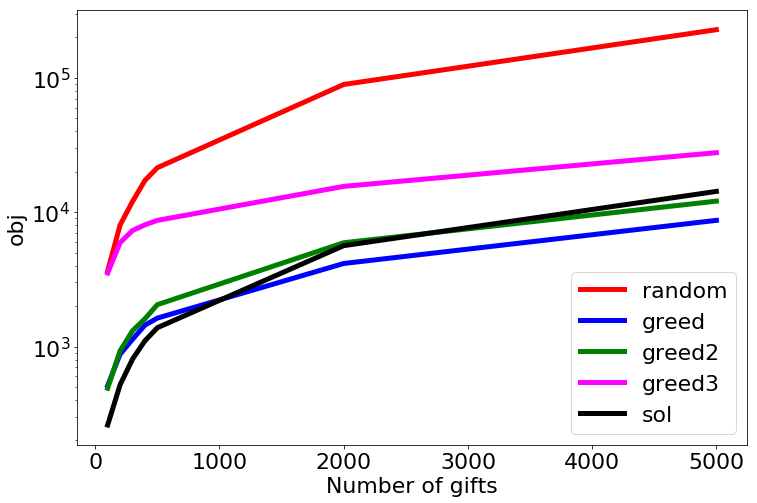

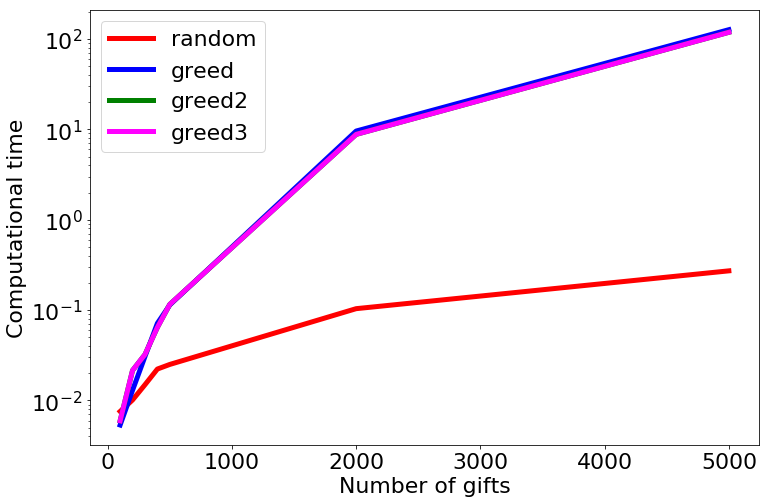

In [171]:
vis(objs,times)

In [19]:
# rand_solution = problem.Randomize_solver()
# # test solution
# print(problem.objective(rand_solution))

# greed_solution = problem.Greedy_solver()
# # test solution
# print(problem.objective(greed_solution))

# deep_greed_solution = problem.Greedy_solver_deep()
# # test solution
# print(problem.objective(deep_greed_solution))

In [75]:
np.array([-10,-1,2,1]).max()

2

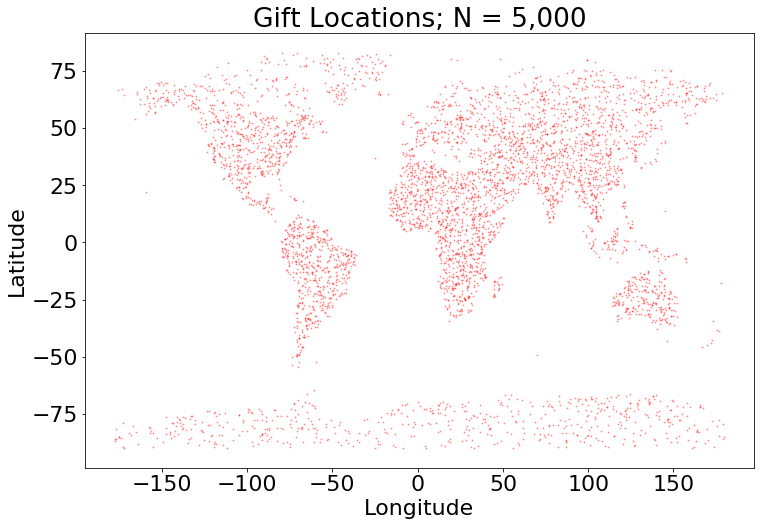

In [129]:
# distribution for considered subset of gifts !!DOESN'T WORK BECAUSE OF dist matrix calculation!!

gift_num = 5000
Problem(gifts[:gift_num], sample_submission[sample_submission.GiftId<=gift_num]).distribution()

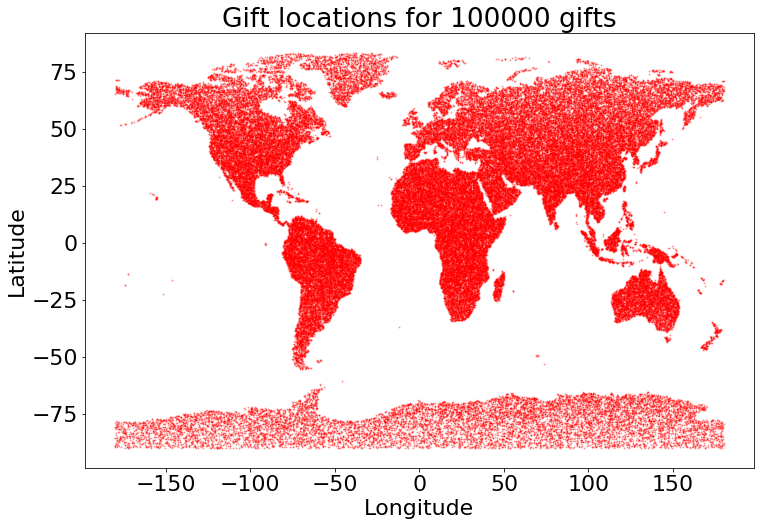

In [28]:
gifts.plot.scatter('Longitude', 'Latitude', alpha=0.3, s=1, color='red',figsize = (12,8))
plt.title('Gift locations for ' + str(len(gifts)) + " gifts")
plt.show()
plt.savefig('All_gift_locations.png')

In [ ]:
# coordinates = np.zeros([solution["TripId"]),2])

# for i in range(m-1):
# #     print(i)
#     coordinates[i*m:i*(m)+m,0] = np.linspace(0,m-1,m)
    
#     coordinates[i*m:i*(m)+m,1] = i*np.ones(m)



In [236]:
def visualise(solution, coor):

        
#     # Gift locations
# #     plt.figure()
#     self.df_data.plot.scatter('Longitude', 'Latitude', alpha=0.3, s=1, color='red',figsize = (12,8))
#     plt.title('Gift Locations; N = {:,}'.format(len(self.df_data)))
#     plt.show()
#     plt.savefig('All_gift_locations.png')   
    
    
#     def vis(x, w, c, deflect):

#     nm = x.shape[0]
    plt.figure(figsize = (15,10))
    ad_m = np.zeros( [len(solution["TripId"]),len(solution["TripId"])] )
    G = nx.from_numpy_matrix(ad_m, create_using = nx.MultiDiGraph())
    
    nx.draw_networkx_nodes(G, coor, node_size=200)

# #     x_dic and v_dic for edges and vertex dictionaries
#     x_dic = {}    
    
#     for i in range(nm):
#         for j in range(nm):
            
#             if(x[i,j]!=0):
                
#                 x_dic[(i,j)] = x[i,j]  
                
    v_dic = {}
    print(solution.TripId[4])
    for i in range(len(solution["TripId"])):
        v_dic[i] = str(int(solution.TripId[i]))
        
#     nx.draw_networkx_edges(G, new_coor,G.edges())
#     nx.draw_networkx_edge_labels(G, new_coor,x_dic)
    nx.draw_networkx_labels(G ,coor, v_dic)    

1
4


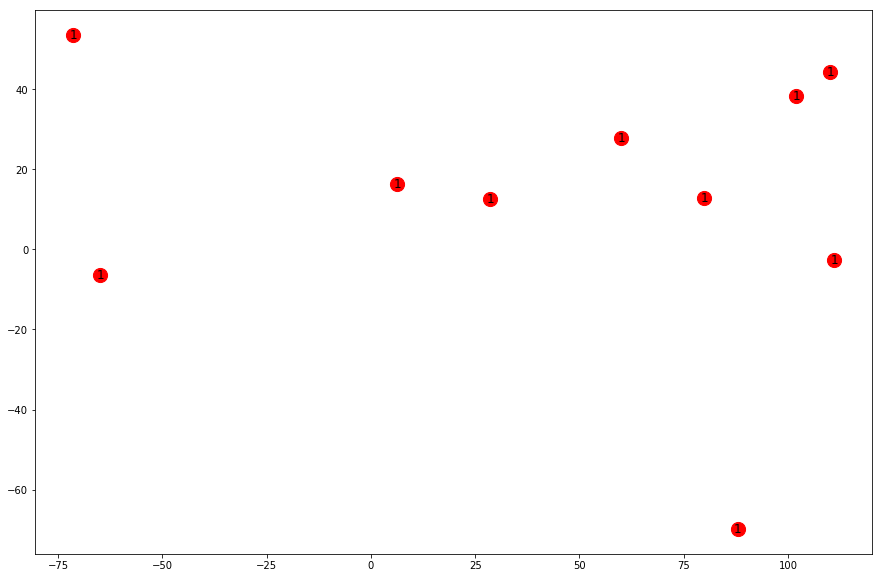

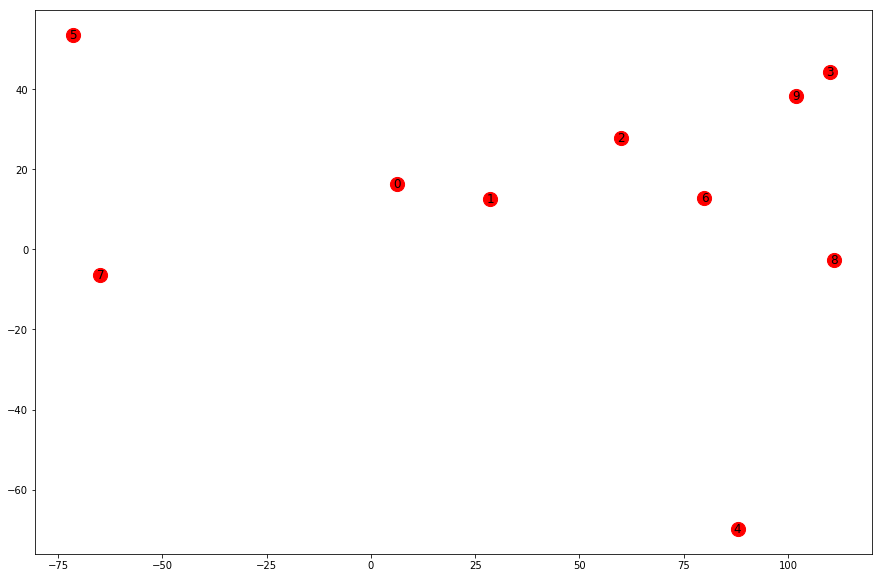

In [237]:
gifts = pd.read_csv('gifts.csv')
sample_submission= pd.read_csv('sample_submission.csv') 

gift_num = 10

problem=Problem(gifts[:gift_num], sample_submission[sample_submission.GiftId<=gift_num])
greed_solution = problem.Greedy_solver()
sub_solution = problem.solution


coordinates = np.zeros([len(sub_solution["TripId"]),2])
coordinates[:,0] = np.array(gifts[:gift_num].Longitude)
coordinates[:,1] = np.array(gifts[:gift_num].Latitude)

visualise(greed_solution, coordinates)
visualise(sub_solution, coordinates)


In [221]:
np.array(greed_solution.GiftId)

array([ 6,  8,  1,  2,  3,  7, 10,  4,  9,  5], dtype=int64)

In [196]:
len(problem.solution["TripId"])

100

In [201]:
np.array(gifts[:gift_num].Latitude)

array([ 16.34576887,  12.49474931,  27.79461514,  44.42699238,
       -69.85408841,  53.56796981,  12.90258404,  -6.29109889,
        -2.68531605,  38.42886187,  39.09014301, -15.57493423,
        73.18964973,  57.06828972, -68.88467273, -40.7404097 ,
       -66.32439126,  48.75063102,  34.22210516, -73.08386235,
        18.67162431,  47.36264464, -21.28284063,  36.40358683,
        52.21852402,  18.36674575,  29.44142677,  76.3334846 ,
        65.07172593,  38.38065982,  62.51995974,  58.91667586,
        -8.63406954, -76.19407272,  52.56357329,  31.04598104,
        50.24205076,  16.01750074,   8.05847094,  75.26151031,
        18.7085646 ,  68.485726  , -77.05117865,  42.32078332,
        55.79813974,  67.72614563,  29.96169351,  39.49089536,
        -1.95496237,  56.8165711 ,  22.15745712,  64.8631213 ,
        33.57699426,  28.31569726,  -8.25094633,   1.8477319 ,
        50.66453019,  31.69268275, -84.85548512,  65.15713359,
        37.71925992,   6.96306452, -30.89580172,  54.25

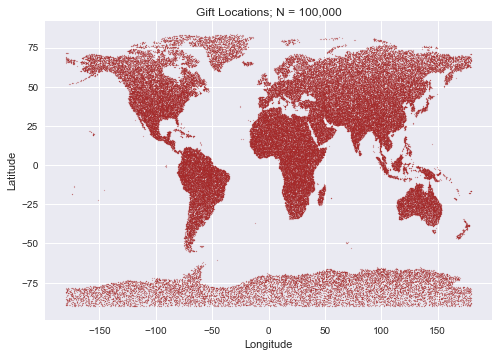

C:\Users\Equistant-adm\Anaconda2\lib\site-packages\ipykernel\__main__.py:31: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Users\Equistant-adm\Anaconda2\lib\site-packages\ipykernel\__main__.py:32: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


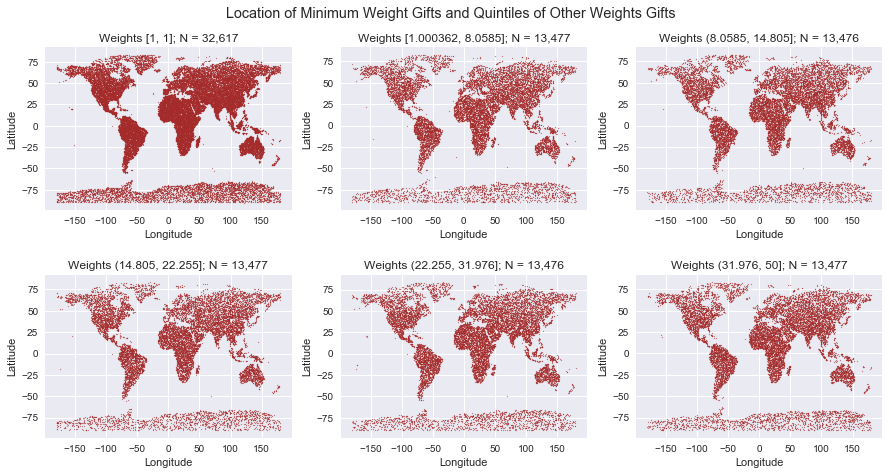

In [7]:
import seaborn as sns
import math

gifts = pd.read_csv('gifts.csv')


# All gift locations
gifts.plot.scatter('Longitude', 'Latitude', alpha=0.3, s=1, color='brown')
plt.title('Gift Locations; N = {:,}'.format(len(gifts)))
plt.show()
plt.savefig('All_gift_locations.png')

# Create category for Weight = 1 and quintile of other weights
gifts['Weight_Group'] = pd.qcut(gifts.Weight.replace(1, np.nan), 5)
gifts.Weight_Group = gifts.Weight_Group.cat.add_categories('[1, 1]').fillna('[1, 1]')
categories = list(gifts.Weight_Group.cat.categories)
categories = [categories[-1]] + categories[:-1]
gifts.Weight_Group = gifts.Weight_Group.cat.reorder_categories(categories)

gifts.groupby('Weight_Group').size()

fig, axes = plt.subplots(nrows=2, ncols=3)
plt.subplots_adjust(top=0.90)
plt.suptitle('Location of Minimum Weight Gifts and Quintiles of Other Weights Gifts')
fig.set_size_inches(15, 7)
for count, (group, df) in enumerate(gifts.groupby('Weight_Group')):
    row = math.floor(count / 3)
    col = count % 3
    df.plot.scatter('Longitude', 'Latitude', alpha=0.5, s=1, ax=axes[row][col], color='brown')
    axes[row][col].set_title('Weights {:}; N = {:,}'.format(group, len(df)))
plt.subplots_adjust(hspace=0.4)
plt.show()
plt.savefig('Gift_locations_by_weight.png')

In [63]:
all_trips = greed_solution.TripId
all_trips[all_trips.TripId==i].GiftId

AttributeError: 'Series' object has no attribute 'TripId'

In [72]:
greed_solution


,GiftId,TripId
0,925,1
1,600,1
2,271,1
3,961,1
4,28,1
5,755,1
6,715,1
7,996,1
8,991,1
9,644,1


In [93]:
rand_solution = problem.Randomize_solver()
# test solution
problem.objective(rand_solution)

1
16
8
96


IndexError: index 97 is out of bounds for axis 0 with size 97

In [52]:
sample_submission

,GiftId,TripId
0,1,0
1,2,1
2,3,2
3,4,3
4,5,4
5,6,5
6,7,6
7,8,7
8,9,8
9,10,9


In [58]:
len(np.delete(np.array([0]),0))

0

In [46]:
a = np.array([[1,8],[1,4]])

In [47]:
a

array([[1, 8],
       [1, 4]])

In [43]:
b,c = np.where(a == a.min())

In [44]:
zip(b,c)

[(0, 0), (1, 0)]

In [48]:
zip(np.where(a == a.min()))

[(array([0, 1], dtype=int64),), (array([0, 0], dtype=int64),)]

(100L,)

In [73]:
np.where(problem.dist[:-i,-1] == problem.dist[:-i,-1].min())

AttributeError: 'tuple' object has no attribute 'unique'

In [59]:
problem.dist[:-2,-1]

array([  8189.97682785,   8618.19066538,   6916.92320685,   5067.48723962,
        17774.96363486,   4051.05692481,   8572.84151248,  10707.08167793,
        10306.13691955,   5734.44892182,   5660.91781298,  11739.39706693,
         1869.22566519,   3661.83910846,  17667.16952882,  14537.67026662,
        17382.47921901,   4586.7205578 ,   6202.21892498,  18134.09811143,
         7931.35350216,   4741.05760172,  12374.08730011,   5959.64923128,
         4201.10845033,   7965.25445175,   6733.80610781,   1519.64717748,
         2771.89760653,   5739.80874433,   3055.64106129,   3456.30794774,
        10967.60812746,  18479.93772453,   4162.74072199,   6555.38781329,
         4420.88224972,   8226.47857786,   9111.48231347,   1638.84528021,
         7927.2459298 ,   2392.27811969,  18575.24355599,   5301.68700145,
         3803.07334291,   2476.73960331,   6675.95508587,   5616.356185  ,
        10224.92529563,   3689.82894227,   7543.74657883,   2795.09338262,
         6273.95198476,  

In [111]:
a = np.array([[1,8],[1,4]])
tmp = np.where(a[:,-2] == a[:,-2].min())

In [112]:
a

array([[1, 8],
       [1, 4]])

In [118]:
problem.weights

array([  1.        ,  15.52447957,   8.05849862,   1.        ,
        25.08889192,  38.00015126,  44.20661624,   1.        ,
         1.        ,  35.70131124,  27.57992144,  14.55197414,
         4.98356233,  23.65599779,   1.        ,  20.85176452,
         1.        ,   6.88447878,  45.80868301,  43.21221952,
         1.        ,  27.11317318,   1.        ,   1.        ,
        26.4288452 ,  38.39440568,  14.39033   ,   1.        ,
         4.6424679 ,  45.72847367,  29.15974093,   8.92293397,
        24.84353587,   1.        ,   1.        ,  14.28245276,
         1.        ,   1.        ,   1.        ,   1.        ,
        37.63891837,  29.7005922 ,   6.24581768,   8.4446355 ,
         6.52314409,   1.        ,   1.        ,  14.76200542,
         1.        ,  14.04809734,  38.9453026 ,   1.        ,
        28.4738708 ,   1.36699187,   1.        ,  30.25696957,
        25.35367826,  21.20053354,  42.80664664,   1.        ,
        24.96041596,   1.        ,  14.00143642,  16.16

In [119]:
aa = np.array([1,3,6,8])

In [126]:
random.choice(aa)

6